In [1]:
import numpy as np
import pandas as pd

In [2]:
from datetime import datetime

current_time = datetime.now().strftime("%H:%M:%S")
print("Time started =", current_time)

Time started = 01:20:53


In [3]:
data = pd.read_csv("train.csv")

# EDA

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data.shape

(7613, 5)

## Initial cleanup

### Handling NaNs

In [6]:
def na_counts(df):
    na_columns = df.columns[df.isna().any()]
    if len(na_columns)==0:
        return 0
    return df[na_columns].isna().apply(lambda x: x.value_counts())

In [7]:
na_counts(data)

,keyword,location
False,7552,5080
True,61,2533


In [8]:
data = data.fillna("")

In [9]:
na_counts(data)

0

## Exploring variables

In [10]:
from sklearn.metrics import mutual_info_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns

### Target value counts

0    4342
1    3271
Name: target, dtype: int64


([<matplotlib.patches.Wedge at 0x7f3d9d8d31f0>,
 [Text(-0.24110481617711207, 1.0732513534192263, '0'),
  Text(0.24110481617711216, -1.0732513534192263, '1')])

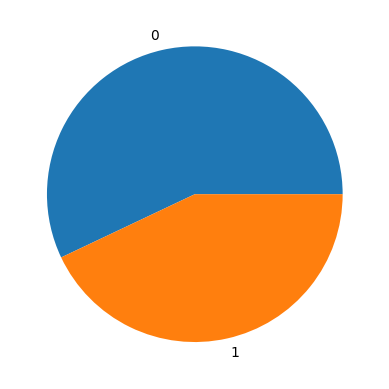

In [11]:
print(data.target.value_counts())
plt.pie(data.target.value_counts(), labels = (0,1))

In [12]:
def sorted_corr_coefs(df, column_name, target_column_name):
    dv = DictVectorizer(sparse=False)
    dict = data[[column_name]].to_dict(orient='records')
    columns = np.transpose(dv.fit_transform(dict))
    corrcoefs = []
    for col in columns:
        corrcoefs.append(np.corrcoef(col, data[target_column_name])[0, 1])
    named_list = list(zip(dv.get_feature_names_out(), corrcoefs))
    named_list.sort(key=lambda tup: tup[1], reverse = True)
    return named_list

In [13]:
# Analyzing mutual info score I want to compare it with such of a shuffled data
shuffled_target = data.target.sample(frac=1, random_state=10)

### Variable "keyword"

In [14]:
data.keyword.value_counts()

                         61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [15]:
mutual_info_score(data['keyword'], data['target']), mutual_info_score(data['keyword'], shuffled_target)

(0.16947295623391556, 0.013396592412637555)

In [16]:
sorted_corr_coefs(data, "keyword", "target")[:30], sorted_corr_coefs(data, "keyword", "target")[-30:]

([('keyword=derailment', 0.08267501656791963),
  ('keyword=wreckage', 0.08267501656791963),
  ('keyword=debris', 0.080516616503906),
  ('keyword=outbreak', 0.08006342865745676),
  ('keyword=typhoon', 0.07783761510564755),
  ('keyword=oil%20spill', 0.0778376151056471),
  ('keyword=suicide%20bombing', 0.07198080078232648),
  ('keyword=suicide%20bomber', 0.0695037416094893),
  ('keyword=suicide%20bomb', 0.06653252563655127),
  ('keyword=rescuers', 0.06653252563655115),
  ('keyword=nuclear%20disaster', 0.06522974951590454),
  ('keyword=evacuated', 0.06394441989331812),
  ('keyword=bombing', 0.06263006921820151),
  ('keyword=razed', 0.06261005839265929),
  ('keyword=wildfire', 0.05986365507855725),
  ('keyword=airplane%20accident', 0.058687591148766684),
  ('keyword=wild%20fires', 0.057003478164473),
  ('keyword=buildings%20on%20fire', 0.05582460651063401),
  ('keyword=mass%20murder', 0.055824606510633965),
  ('keyword=bridge%20collapse', 0.05476512390487407),
  ('keyword=forest%20fires', 0

### Variable "location"

In [17]:
data.location.value_counts()

                                2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: location, Length: 3342, dtype: int64

In [18]:
mutual_info_score(data['location'], data['target']), mutual_info_score(data['location'], shuffled_target)

(0.31254635681695697, 0.30151620936968093)

In [19]:
sorted_corr_coefs(data, "location", "target")[:10], sorted_corr_coefs(data, "location", "target")[-10:]

([('location=USA', 0.05101140011993961),
  ('location=Mumbai', 0.047195302822488135),
  ('location=India', 0.045857912019408635),
  ('location=Nigeria', 0.043700694813182915),
  ('location=Washington, DC', 0.030239642046364305),
  ('location=Bend, Oregon', 0.026416230235620966),
  ('location=Nairobi-KENYA', 0.02641623023562073),
  ('location=Calgary', 0.026416230235620723),
  ('location=Nigeria ', 0.02641623023562072),
  ('location=Portland, Oregon', 0.02641623023562072)],
 [('location=Coventry', -0.022250773490737206),
  ('location=Texas, USA', -0.02225077349073725),
  ('location=Indiana', -0.02225077349073729),
  ('location=Wisconsin', -0.02225077349073729),
  ('location=ss', -0.024151501376051914),
  ('location=London, England', -0.024151501376051928),
  ('location=Morioh, Japan', -0.024376103182953163),
  ('location=Pennsylvania, USA', -0.026330931421991832),
  ('location=304', -0.029860396014459598),
  ('location=New York', -0.04004435015466763)])

### Variable "text"

In [20]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer

##### Count vectorizer does similar thing to usual dict vectorizer. It splits texts into separate words and create a column for each word. Than it assigns a number of occurences for each word in each cell of a particular column. In our case it will be `text`

In [21]:
count_vectorizer = CountVectorizer()
vectors = count_vectorizer.fit_transform(data['text'])
vectors.shape

(7613, 21637)

##### Let's see how the first text look like in terms of words frequencies

In [22]:
frequencies = list(zip(count_vectorizer.get_feature_names_out(), vectors[0].todense().getA()[0]))
[x for x in frequencies if x[1] > 0], data.text[0]

([('all', 1),
  ('allah', 1),
  ('are', 1),
  ('deeds', 1),
  ('earthquake', 1),
  ('forgive', 1),
  ('may', 1),
  ('of', 1),
  ('our', 1),
  ('reason', 1),
  ('the', 1),
  ('this', 1),
  ('us', 1)],
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all')

##### Interesting! There are hashtags, i.e. #earthquake, but they are extracted as simple words. Let's fix this

#### Hashtags

In [23]:
hashtag_pattern = r'#(\w+)'

hashtags = data.text.str.lower().str.findall(hashtag_pattern)
ht_c_vect = CountVectorizer(min_df=5, analyzer=lambda x: x)
ht_vectors = ht_c_vect.fit_transform(hashtags)
ht_c_vect.get_feature_names_out(), len(ht_c_vect.get_feature_names_out())

(array(['1', 'abstorm', 'africa', 'afterlife', 'allah', 'animalrescue',
        'antioch', 'armageddon', 'art', 'bb17', 'bbc', 'best',
        'bestnaijamade', 'beyhive', 'breaking', 'business', 'california',
        'cnn', 'course', 'dance', 'directioners', 'disaster', 'dnb',
        'drought', 'dubstep', 'earthquake', 'edm', 'emergency',
        'emmerdale', 'fashion', 'fukushima', 'gbbo', 'genocide', 'god',
        'hailstorm', 'handbag', 'hiring', 'hiroshima', 'hot', 'ices',
        'india', 'iphone', 'irandeal', 'isis', 'islam', 'japan', 'job',
        'jobs', 'kerricktrial', 'kindle', 'landslide', 'lgbt', 'libya',
        'lies', 'mh370', 'military', 'mtvhottest', 'mumbai', 'myanmar',
        'news', 'newyork', 'nowplaying', 'np', 'nuclear', 'nursing',
        'okwx', 'pakistan', 'pantherattack', 'phoenix', 'photography',
        'prebreak', 'preparedness', 'prophetmuhammad', 'quote', 'quran',
        'refugees', 'rohingya', 'rt', 'science', 'seattle', 'sismo',
        'sittwe', 

In [24]:
data['hashtags'] = hashtags
data

,id,keyword,location,text,target,hashtags
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,[earthquake]
1,4,,,Forest fire near La Ronge Sask. Canada,1,[]
2,5,,,All residents asked to 'shelter in place' are ...,1,[]
3,6,,,"13,000 people receive #wildfires evacuation or...",1,[wildfires]
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,"[alaska, wildfires]"
...,...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1,[]
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1,[]
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,[]
7611,10872,,,Police investigating after an e-bike collided ...,1,[]


#### URLs

##### Now let's just have a look at random keywords from the top of the list:

In [25]:
count_vectorizer.get_feature_names_out()[0:100]

array(['00', '000', '0000', '007npen6lg', '00cy9vxeff', '00end', '00pm',
       '01', '02', '0215', '02elqlopfk', '02pm', '03', '030', '033',
       '034', '039', '03l7nwqdje', '04', '05', '05th', '06', '060', '061',
       '06jst', '07', '073izwx0lb', '08', '0840728', '0853',
       '087809233445', '0880', '08lngclzsj', '09', '0abgfglh7x',
       '0ajisa5531', '0blkwcupzq', '0btniwagt1', '0bvk5tub4j',
       '0c1y8g7e9p', '0cr74m1uxm', '0cxm5tkz8y', '0dqjeretxu',
       '0drqlrsgy5', '0dxvz7fdh3', '0erisq25kt', '0f8xa4ih1u',
       '0fekgyby5f', '0fs9ksv5xk', '0ghk693egj', '0gidg9u45j',
       '0gknpy4lua', '0h7oua1pns', '0iw6drf5x9', '0iyuntxduv',
       '0jfnvaxfph', '0jmkdtcymj', '0kccg1bt06', '0keh2treny',
       '0krw1zyahm', '0l', '0la1aw9uud', '0llwuqn8vg', '0lmheaex9k',
       '0lpu0gr2j0', '0m1tw3datd', '0mcxc68gzd', '0migwcmtje',
       '0mnpcer9no', '0npzp', '0nr4dpjgyl', '0oms8ri3l1', '0pamznyyuw',
       '0q040stkcv', '0r03c6njli', '0rny349unt', '0rokdutyun',
       '0rsv

##### A lot or weird texts looking like some hashes or something. Let's find where one of them occur in the texts

In [26]:
data.loc[data['text'].str.contains("0cxm5tkz8y", case=False)].text.values[0]

'Sharp rise in women children casualties in Afghan war UN says http://t.co/0CXm5TkZ8y http://t.co/v5aMDOvHOT'

##### So these look like parts of urls. Let's check how many different urls we have

In [27]:
url_pattern =  r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'

In [28]:
data.text[data.text.str.findall(url_pattern).apply(len) > 0].values

array(['@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C',
       'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw',
       '#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi',
       ...,
       'Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5',
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [29]:
data.text.str.findall(url_pattern).apply(lambda x: x[0] if len(x) > 0 else None).value_counts()

http://t.co/qew4c5M1xd    9
http://t.co/KSAwlYuX02    6
http://t.co/q2eBlOKeVE    6
http://t.co/vVPLFQv58P    5
http://t.co/cybKsXHF7d    5
                         ..
http://t.co/NXLEiIJFgS    1
http://t.co/y5Yhbb0hkf    1
http://t.co/GedOxSPpL9    1
http://t.co/4k8OLZv9bV    1
http://t.co/YmY4rSkQ3d    1
Name: text, Length: 3875, dtype: int64

##### Probably some of them might be a good indicator of a target. We might want to create a separate column, such as number of urls in a text or something like that

##### Let's observe correlation of different words with target

In [30]:
columns = np.transpose(vectors.todense().A)
columns.shape

(21637, 7613)

In [31]:
corrcoefs = []
for col in columns:
    corrcoefs.append(np.corrcoef(col, data.target)[0, 1])
named_list = list(zip(count_vectorizer.get_feature_names_out(), corrcoefs))
named_list.sort(key=lambda tup: tup[1], reverse = True)

In [32]:
named_list[0:10], named_list[-10:]

([('http', 0.2126857016032362),
  ('co', 0.19584656255519792),
  ('in', 0.16485584681394716),
  ('california', 0.1304433035954872),
  ('suicide', 0.12401359099263466),
  ('hiroshima', 0.12057003953828943),
  ('killed', 0.11927123983117018),
  ('mh370', 0.1095485856349991),
  ('wildfire', 0.1062656731133471),
  ('northern', 0.10608400609185162)],
 [('if', -0.0686682762655394),
  ('can', -0.07132110403337122),
  ('it', -0.07247470509376949),
  ('full', -0.0730178581511043),
  ('so', -0.07517673569508387),
  ('your', -0.07672163676999283),
  ('body', -0.08359410507385581),
  ('me', -0.08871342288840284),
  ('my', -0.12872670360280616),
  ('you', -0.15300123086640835)])

In [33]:
tags_list = list(filter(lambda tup: "#" in tup[0], named_list))
tags_list[:10], tags_list[-10:]

([], [])

In [34]:
freq_sums = vectors.todense().sum(axis=0).A[0]

In [35]:
named_sums = list(zip(count_vectorizer.get_feature_names_out(), freq_sums))
named_sums = list(filter(lambda tup: tup[1] > 5, named_sums))
print (len(named_sums))
sorted(named_sums, key=lambda tup: tup[1], reverse=True)[0:30]

2406


[('co', 4740),
 ('http', 4309),
 ('the', 3277),
 ('in', 1986),
 ('to', 1949),
 ('of', 1830),
 ('and', 1426),
 ('is', 950),
 ('you', 902),
 ('for', 894),
 ('on', 860),
 ('it', 779),
 ('my', 680),
 ('that', 623),
 ('with', 572),
 ('at', 542),
 ('by', 527),
 ('this', 480),
 ('from', 422),
 ('https', 411),
 ('be', 408),
 ('are', 404),
 ('have', 386),
 ('was', 386),
 ('like', 348),
 ('û_', 348),
 ('amp', 344),
 ('as', 331),
 ('up', 330),
 ('me', 329)]

#### Emoji

In [36]:
import emoji

In [37]:
print(data.text.apply(emoji.distinct_emoji_list)[data.text.apply(emoji.emoji_count) > 0])

2171    [©]
2172    [©]
2173    [©]
2179    [©]
3479    [©]
4390    [©]
7127    [©]
7514    [©]
7527    [©]
7532    [©]
Name: text, dtype: object


# Training Models

### Plan
We are going to run the data through the following pipeline:
1. Clean up
1.1 Remove URLs (or replace)
1.2 Replace emojis with text representation
1.3 Remove hashtags or hash symbols
2. Tokenize 
3. Stem or lemmatize tokens
4. Collect ngrams
5. Vectorize
6. Polynomialize
7. Select best features (K best)
8. Reduce dimensionality (SVD)
9. Train and validate models (Naive Bayes, Linear and Trees)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import scipy.sparse as sp
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_selection import SelectKBest, chi2

In [39]:
import nltk

In [40]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/iliav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/iliav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/iliav/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/iliav/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [41]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet

from sklearn.preprocessing import FunctionTransformer
import re

In [42]:
stopwords_english = stopwords.words('english')
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

def pos_for_tag(tag):
        if tag.startswith('V'):
            return 'v'
        elif tag.startswith('J'):
            return('a')
        elif tag.startswith('R'):
            return('r')
        else:
            return('n')
        
def lemma_preprocessor_full(text):
    words=[lemmatizer.lemmatize(w, pos_for_tag(tag)) for w, tag in pos_tag(re.split("\\s+",text))]
    return ' '.join(words)

def lemma_preprocessor_verb(text):
    words=[lemmatizer.lemmatize(w, 'v') for w in re.split("\\s+",text)]
    return ' '.join(words)

def lemma_preprocessor_adj(text):
    words=[lemmatizer.lemmatize(w, 'a') for w in re.split("\\s+",text)]
    return ' '.join(words)

def lemma_preprocessor_adverb(text):
    words=[lemmatizer.lemmatize(w, 'r') for w in re.split("\\s+",text)]
    return ' '.join(words)

def lemma_preprocessor_noun(text):
    words=[lemmatizer.lemmatize(w, 'r') for w in re.split("\\s+",text)]
    return ' '.join(words)

def stem_preprocessor(text):
    words=[stemmer.stem(w) for w in re.split("\\s+",text)]
    return ' '.join(words)

In [43]:
def url_clean(df):
    df = df.copy()
    df.text = df.text.replace(url_pattern, '', regex=True)
    return df

url_cleaner = FunctionTransformer(url_clean)

In [44]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=42)
df_full_train.shape, df_test.shape

((6090, 6), (1523, 6))

In [45]:
settings = {
    'preprocessors' : [('None', None)],
    'stopwords' : [('None', None)],
    'ngram_ranges' : [('1_1', (1, 1))],
    'best_ks' : [('1000', 1000)],
    'max_polys' : [('1', 1)]
}

In [46]:
X_full_train = df_full_train.drop('target', axis=1)
y_full_train = df_full_train.target
cv = model_selection.StratifiedKFold(4, shuffle=True, random_state=55)

In [47]:

def truncated_vectors(features, components_range, n_iter=20):
    n_work = sum([train_vectors_combinations[k].shape[1] for k in features])
    c_work = sum(coarse_components_range)    
    total_work = n_work*c_work
    done_work = 0
    
    result = {}
    for f in features:
        dict = {}
        for n in components_range:
            clear_output(wait=True)
            done_percentage = round(100*done_work/total_work)
            print(f"{done_percentage}% completed")
            iter_work = n*train_vectors_combinations[f].shape[1]
            iter_percentage = round(100*iter_work/total_work)
            print (f"Processing {n} components in {f} ({iter_percentage}%)")
            svd = TruncatedSVD(n_components=n, n_iter=20, random_state=42)
            vectors = svd.fit_transform(train_vectors_combinations[f])
            dict[n] = vectors
            done_work+=iter_work
        result[f] = dict
    return result

In [48]:
%load_ext autoreload
%autoreload 2

In [122]:
from preprocess_util import default_preprocess_settings, prepare_cross_val_vectors, my_cross_val_score

In [151]:
%time
isolated_steps_settings = {
    'Pure Text': {},
    'Url Cleaner': {'url_cleaner': url_cleaner},
    'Stemming': {'preprocessor': stem_preprocessor},
    'Lemmatization': {'preprocessor': lemma_preprocessor_full},
    'Keyword': {'kw': True},
    'Location': {'loc': True},
    'Hashtags': {'hashtags': True},    
    'Stopwords': {'stopwords': stopwords_english},    
    '1-2 words ngrams': {'ngram_range': (1, 2)},
    '1-3 words ngrams': {'ngram_range': (1, 3)},

    'Stopwords + Stemming': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor},  
    'Stopwords + Lemmatization': {'stopwords': stopwords_english, 'preprocessor': lemma_preprocessor_full},
    'Keyword + URL Cleaner': {'url_cleaner': url_cleaner, 'kw': True},
    'Keyword + Stemming': {'url_cleaner': url_cleaner, 'preprocessor': stem_preprocessor},
    'Stopwords + URL Cleaner': {'stopwords': stopwords_english, 'url_cleaner': url_cleaner},
    'Stopwords + Keyword': {'stopwords': stopwords_english, 'kw': True},
    'Stopwords + Location': {'stopwords': stopwords_english, 'loc': True},
    'Stopwords + Hashtags': {'stopwords': stopwords_english, 'hashtags': True},
    'Stopwords + 1-2 ngrams': {'stopwords': stopwords_english, 'ngram_range': (1, 2)},
    'Stopwords + Stemming + Keyword': {'stopwords': stopwords_english, 'kw': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + Location': {'stopwords': stopwords_english, 'Loc': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + Hashtags': {'stopwords': stopwords_english, 'hashtags': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + URL Cleaner': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor, 'url_cleaner': url_cleaner},
    'Stopwords + Stemming + 1-2 ngrams': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor, 'ngram_range': (1, 2)}
}

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.81 µs


In [152]:
best_settings['Naive Bayes'] =  default_settings_updated({'url_cleaner': url_cleaner, 'kw': True})
best_settings['Ridge Classifier'] =  default_settings_updated({'url_cleaner': url_cleaner, 'kw': True, 
                                                               'preprocessor': stem_preprocessor})
best_settings['Logistic Regression'] =  default_settings_updated({'url_cleaner': url_cleaner, 'kw': True})
best_settings['Tree'] =  default_settings_updated({'url_cleaner': url_cleaner, 
                                                   'kw': True, 
                                                   'loc': True,
                                                   'preprocessor': stem_preprocessor,
                                                   'stopwords': stopwords_english})
best_settings['Forest'] =  default_settings_updated({'preprocessor': stem_preprocessor})
best_settings['XGBoost'] =  default_settings_updated({'url_cleaner': url_cleaner, 
                                                   'kw': True, 
                                                   'loc': True,
                                                   'hashtags': True,
                                                   'ngram_range': (1, 2),  
                                                   'preprocessor': stem_preprocessor,
                                                   'stopwords': stopwords_english})

In [153]:
%%time

isolated_steps_vectors = {}
for key, step_settings in isolated_steps_settings.items():
    # print(f"Processing {key}")
    settings = default_preprocess_settings.copy()
    settings.update(step_settings)
    %time isolated_steps_vectors[key] = prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv, settings=settings)

CPU times: user 312 ms, sys: 540 µs, total: 312 ms
Wall time: 312 ms
CPU times: user 257 ms, sys: 0 ns, total: 257 ms
Wall time: 257 ms
CPU times: user 2.27 s, sys: 0 ns, total: 2.27 s
Wall time: 2.27 s
CPU times: user 11.7 s, sys: 94.5 ms, total: 11.8 s
Wall time: 11.8 s
CPU times: user 386 ms, sys: 0 ns, total: 386 ms
Wall time: 386 ms
CPU times: user 351 ms, sys: 0 ns, total: 351 ms
Wall time: 351 ms
CPU times: user 318 ms, sys: 0 ns, total: 318 ms
Wall time: 318 ms
CPU times: user 272 ms, sys: 0 ns, total: 272 ms
Wall time: 272 ms
CPU times: user 594 ms, sys: 0 ns, total: 594 ms
Wall time: 593 ms
CPU times: user 895 ms, sys: 0 ns, total: 895 ms
Wall time: 895 ms
CPU times: user 2.18 s, sys: 0 ns, total: 2.18 s
Wall time: 2.18 s
CPU times: user 11.7 s, sys: 51.6 ms, total: 11.8 s
Wall time: 11.8 s
CPU times: user 279 ms, sys: 9.53 ms, total: 288 ms
Wall time: 288 ms
CPU times: user 2.04 s, sys: 0 ns, total: 2.04 s
Wall time: 2.04 s
CPU times: user 228 ms, sys: 0 ns, total: 228 ms
Wa

### Comparing Different Models and Different Prepared Data Sets 

In [154]:
model_nb = ComplementNB()
model_rc = RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced")
model_lr = LogisticRegression(solver="liblinear", C=1.0, max_iter=500, random_state=42)
model_tree = DecisionTreeClassifier(max_depth=7)
model_forest = RandomForestClassifier(n_estimators=50,
                            max_depth=7,
                            min_samples_leaf=2,
                            random_state=42)
model_xgb = XGBClassifier(learning_rate=0.2,
                          n_estimators=10, 
                          max_depth=7, 
                          min_child_weight=1, 
                          objective="binary:logistic", 
                          seed=42)

In [155]:
from preprocess_util import compare_models

### Simple Preparation

In [156]:
%%time
simple_models = {
        'Naive Bayes': model_nb,
        'Ridge Classifier': model_rc,
        'Logistic Regression': model_lr,
        'Tree': model_tree,
        'Forest': model_forest,
        'XGBoost': model_xgb
    }

simple_comparison_df = compare_models(simple_models, isolated_steps_vectors)

CPU times: user 32.4 s, sys: 41.5 ms, total: 32.5 s
Wall time: 12.5 s


In [157]:
simple_comparison_df

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Pure Text,0.746288,0.722665,0.746945,0.491285,0.447371,0.608026
Url Cleaner,0.749895,0.723004,0.746879,0.496617,0.329134,0.590394
Stemming,0.743402,0.723354,0.741414,0.510582,0.467383,0.615273
Lemmatization,0.734570,0.713045,0.729116,0.577497,0.409643,0.616830
Keyword,0.754432,0.724536,0.752543,0.493702,0.384533,0.613376
Location,0.741562,0.719980,0.744405,0.490866,0.366266,0.623062
Hashtags,0.744734,0.721718,0.746028,0.489505,0.431358,0.612080
Stopwords,0.742728,0.720265,0.738042,0.635354,0.369679,0.633695
1-2 words ngrams,0.736229,0.707665,0.741507,0.484525,0.373759,0.610217


In [158]:
simple_diffs = (simple_comparison_df - simple_comparison_df.loc['Pure Text']).drop('Pure Text')

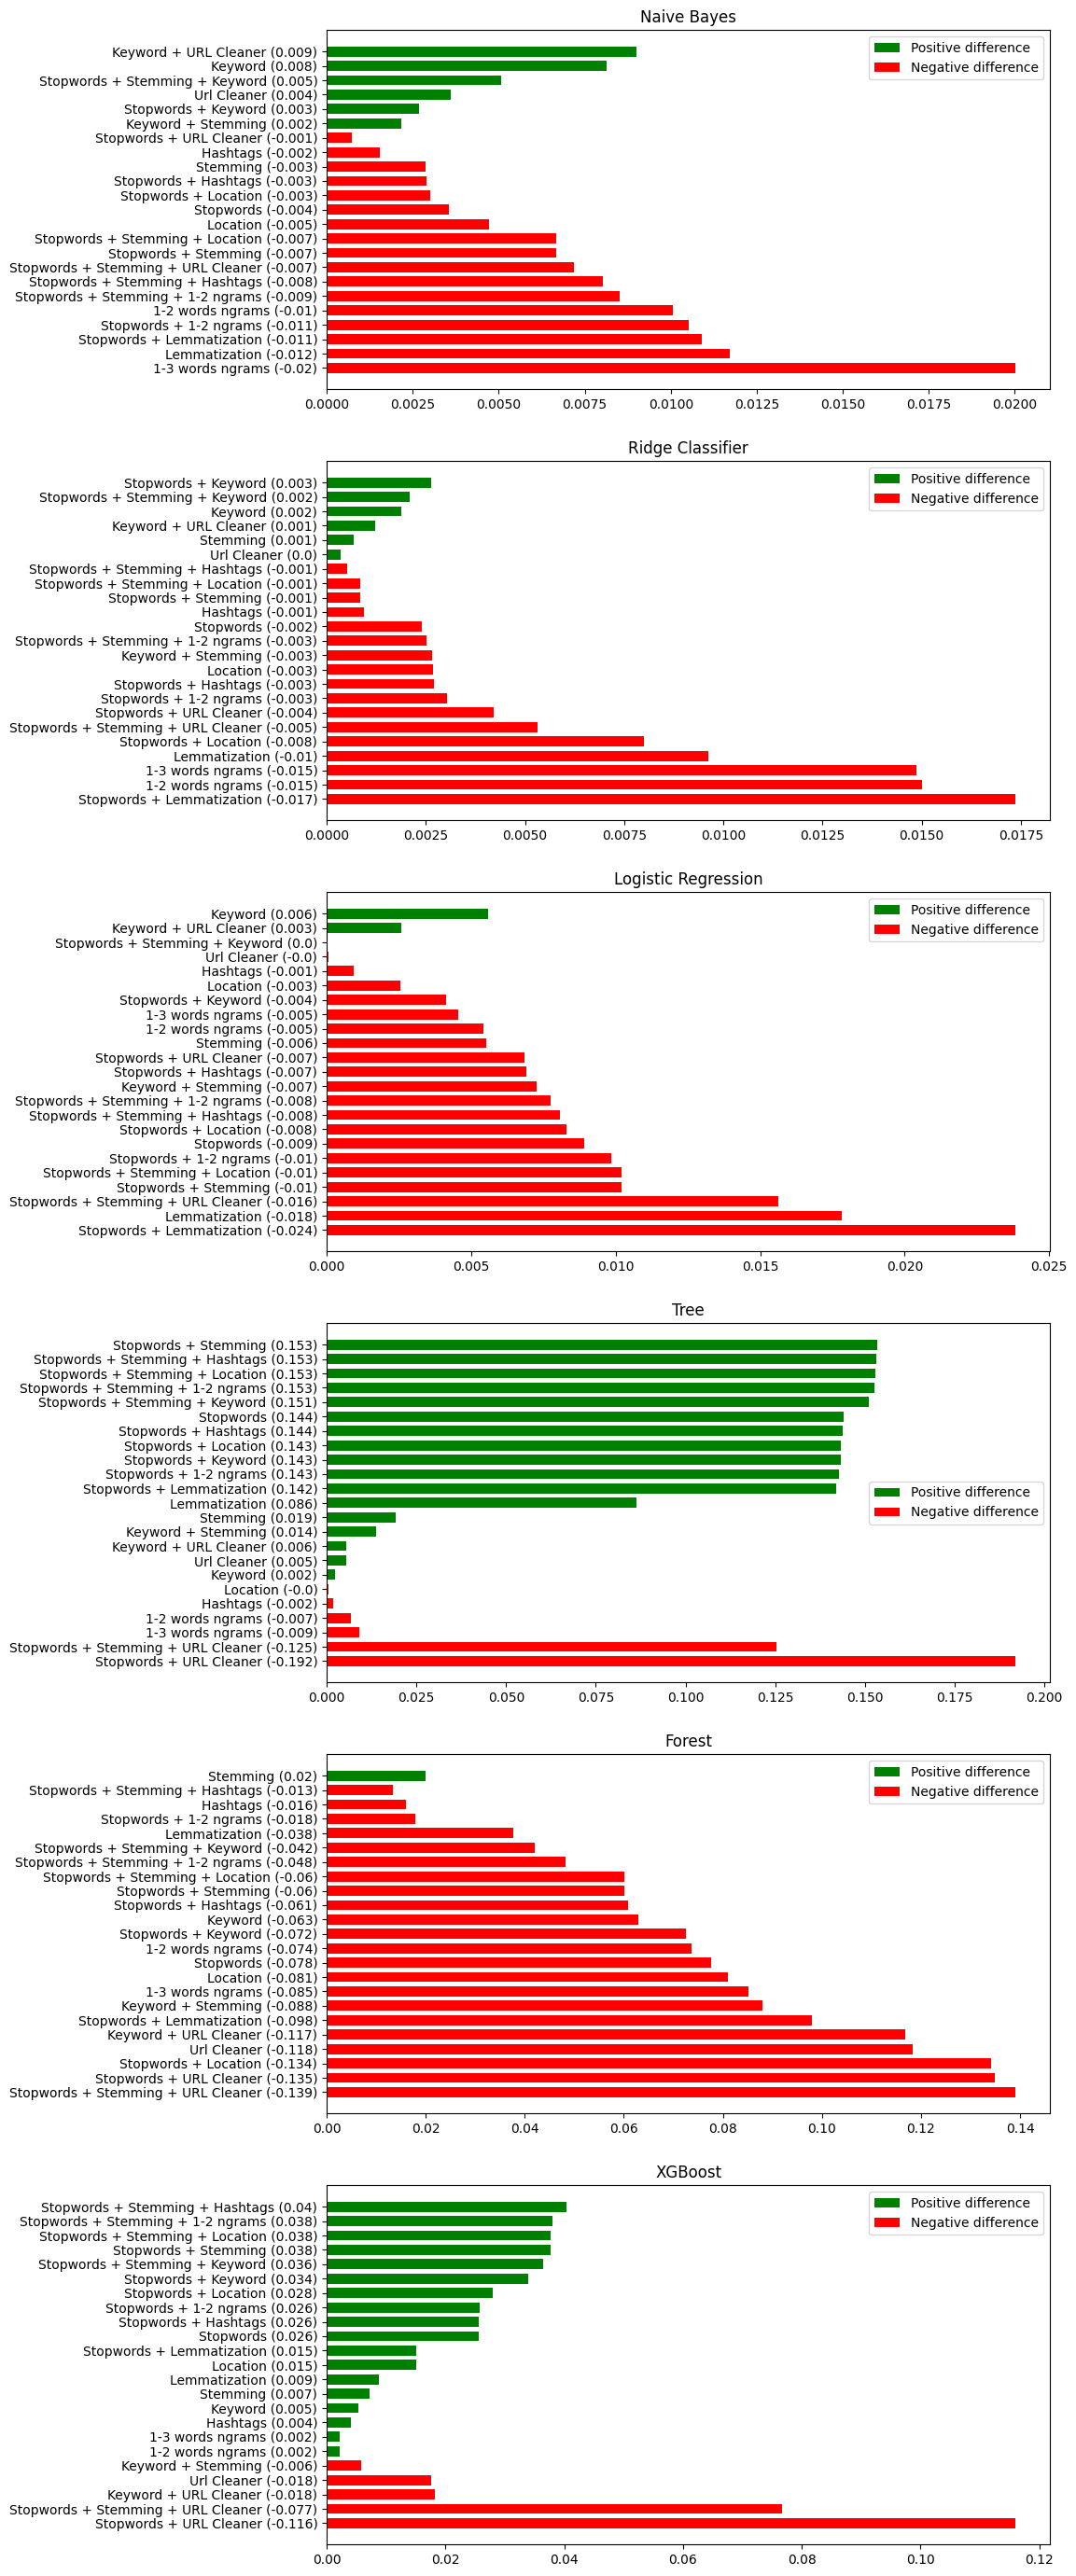

In [159]:
fig, ax = plt.subplots(6, 1, figsize=(10,35))

simple_diffs_reversed = simple_diffs.iloc[::-1]
steps_range = np.arange(simple_diffs_reversed.shape[0])

for i, col in enumerate(simple_diffs.columns):
    diffs_sorted = simple_diffs.sort_values(by=[col])
    steps_range = np.arange(diffs_sorted.shape[0])
    
    axes = plt.subplot(6, 1, i+1) 
    plt.title(col)
    
    scores = diffs_sorted[col].to_list()
    
    positive_scores = [max(0, s) for s in scores]
    negative_scores = [abs(min(0, s)) for s in scores]

    features = list(diffs_sorted.index)
    
    ticks = [f"{feature} ({round(score, 3)})" for feature, score in zip(features, scores)]
    # plot_scores([d for d in scores_dicts if d['model'] == model_name])
    # i+=1
    
    # plt.barh(steps_range, left=simple_comparison_df[col].loc['Pure Text'], width=(simple_diffs[col]).to_list(), height=0.2, label=col)
    plt.barh(steps_range, width=positive_scores, height=0.7, label='Positive difference', color='green')
    plt.barh(steps_range, width=negative_scores, height=0.7, label='Negative difference', color='red')
    
    plt.yticks(steps_range, ticks)
    plt.legend()

plt.legend()

#### Best pipelines per model

In [160]:
def default_settings_updated(settings_update):
    settings = default_preprocess_settings.copy()
    settings.update(settings_update)
    return settings

In [162]:
best_settings = {}

best_settings['Naive Bayes'] =  default_settings_updated({'url_cleaner': url_cleaner, 'kw': True})
best_settings['Ridge Classifier'] =  default_settings_updated({'kw': True, 'stopwords': stopwords_english})
best_settings['Logistic Regression'] =  default_settings_updated({'kw': True})
best_settings['Tree'] =  default_settings_updated({'preprocessor': stem_preprocessor,
                                                   'stopwords': stopwords_english})
best_settings['Forest'] =  default_settings_updated({'preprocessor': stem_preprocessor})
best_settings['XGBoost'] =  default_settings_updated({'hashtags': True,
                                                      'preprocessor': stem_preprocessor,
                                                      'stopwords': stopwords_english})
record_dict = {'Features': 'Best preparation'}

for model_key, model in simple_models.items():
    settings = best_settings[model_key]
    vectors = prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv, settings=settings)
    score = my_cross_val_score(model, vectors['splits']).mean()
    record_dict[model_key] = score

best_preparation_df = pd.DataFrame([record_dict])
best_preparation_df.set_index('Features', inplace=True)

In [163]:
pd.concat((simple_comparison_df, best_preparation_df))

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Pure Text,0.746288,0.722665,0.746945,0.491285,0.447371,0.608026
Url Cleaner,0.749895,0.723004,0.746879,0.496617,0.329134,0.590394
Stemming,0.743402,0.723354,0.741414,0.510582,0.467383,0.615273
Lemmatization,0.734570,0.713045,0.729116,0.577497,0.409643,0.616830
Keyword,0.754432,0.724536,0.752543,0.493702,0.384533,0.613376
Location,0.741562,0.719980,0.744405,0.490866,0.366266,0.623062
Hashtags,0.744734,0.721718,0.746028,0.489505,0.431358,0.612080
Stopwords,0.742728,0.720265,0.738042,0.635354,0.369679,0.633695
1-2 words ngrams,0.736229,0.707665,0.741507,0.484525,0.373759,0.610217


### Polynomialization and dim reduction

In [ ]:
# def k_best_range_settings(poly=False, k_best_range=[])
#     param_dict = {}
#     param_dict['poly2']: {
#         'poly2_k_best__poly2': ['passthrough', PolynomialFeatures(2)],
#         'poly2_k_best__k_best__k': k_best_range
#     }

#     param_dict['non_poly']: {
#     'poly2_k_best__poly2': ['passthrough', PolynomialFeatures(2)],
#     'poly2_k_best__k_best__k': np.linspace(200, 2000, 5, dtype=int)        
#     }
#     param_dict = 'poly2_k_best': [None, poly2_k_best_pipeline],
#     return {
#     'poly2_k_best': [None, poly2_k_best_pipeline],
#     'poly2_k_best__poly2': ['passthrough', PolynomialFeatures(2)],
#     'poly2_k_best__k_best__k': np.linspace(200, 2000, 5, dtype=int)
# }
#     if k_best is None and poly:
#         raise ValueError("polynomialization should be followed with select k best")
    

In [389]:
from matplotlib.pyplot import cm

In [249]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def kw_to_dict(series):
    return [{'keyword': item[1]} for item in series.items()]

kw_to_dict_transformer = FunctionTransformer(kw_to_dict)

kw_pipeline = Pipeline(steps=[('kw_to_dict', kw_to_dict_transformer),
                              ('d_vect', DictVectorizer())])

text_vectorizer_transformer = ColumnTransformer([('text_c_vect', CountVectorizer(min_df=5), 'text')])
                                                    
text_kw_vectorizer_transformer = ColumnTransformer([('text_c_vect', CountVectorizer(min_df=5), 'text'),
                                                    ('kw_dict_vect', kw_pipeline, 'keyword')])
text_hashtags_vectorizer_transformer = ColumnTransformer([('text_c_vect', CountVectorizer(min_df=5), 'text'),
                                                          ('hashtags_c_vect', CountVectorizer(min_df=5, analyzer=lambda x: x), 'hashtags')])

poly2_k_best_pipeline = Pipeline(steps=[('poly2', PolynomialFeatures(2)),
                                        ('k_best', SelectKBest(chi2))])


In [250]:
complete_pipeline = Pipeline(steps=[('url_cleaner', url_cleaner),
                                    ('vectorizer', text_kw_vectorizer_transformer),
                                    ('poly2_k_best', poly2_k_best_pipeline),
                                    ('svd', TruncatedSVD()),
                                    ('classifier', model_nb)])

In [301]:
%%time
import warnings

def k_range_scores(pipe, k_range, default_params={}):
    param_grid_default = default_params.copy() 
    param_grid_default.update({
        'poly2_k_best': [None]
    })
    
    param_grid_k_range = default_params.copy()
    param_grid_k_range.update({
        'poly2_k_best__poly2': ['passthrough', PolynomialFeatures(2)],
        'poly2_k_best__k_best__k': k_range
    })
    range_k_grid_search = GridSearchCV(pipe, 
                                   param_grid = param_grid_k_range,
                                   scoring='f1',
                                   cv=cv)
    default_grid_search = GridSearchCV(pipe, 
                                   param_grid = param_grid_default,
                                   scoring='f1',
                                   cv=cv)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        range_results = range_k_grid_search.fit(df_full_train, y_full_train)
    
    default_results = default_grid_search.fit(df_full_train, y_full_train)
    return {
        'range': range_results,
        'default': default_results
    }

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 10.7 µs


In [358]:
%%time
import warnings

def svd_n_range_scores(pipe, n_range, no_poly_k=1000, poly_2_k=1000, defaults={}):
    variable_defaults = {
        'Pure Text': {
            'poly2_k_best': ['passthrough']
         },
        f'No Poly, Best {no_poly_k}': {
            'poly2_k_best__poly2': ['passthrough'],
            'poly2_k_best__k_best__k': [no_poly_k]
        },
        f'Poly 2, Best {poly_2_k}': {
            'poly2_k_best__k_best__k': [poly_2_k]
        }    
    }
    
    results = {}
    for label, param_grid in variable_defaults.items():
        print (label, param_grid)
        param_grid_ranged = defaults.copy()
        param_grid_ranged.update(param_grid)
        param_grid_no_svd = param_grid_ranged.copy() 
        param_grid_ranged.update({
            'svd__n_components': n_range
        })
        param_grid_no_svd.update({
            'svd': ['passthrough']
        })
            
        
        %time 
        grid_search = GridSearchCV(pipe, 
                                   param_grid = param_grid_ranged,
                                   scoring='f1',
                                   cv=cv)
        
        grid_search_no_svd = GridSearchCV(pipe, 
                                       param_grid = param_grid_no_svd,
                                       scoring='f1',
                                       cv=cv)
        # with warnings.catch_warnings():
        #     warnings.simplefilter("ignore")
        range_results = grid_search.fit(df_full_train, y_full_train)
        no_svd_results = grid_search_no_svd.fit(df_full_train, y_full_train)
        results[label] = {
            'range': range_results,
            'no_svd': no_svd_results
        }
        
        
    return results

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.63 µs


In [239]:
k_range_results_nb = k_range_scores(complete_pipeline, np.linspace(400, 2100, 5, dtype=int),
                                       default_params={
                                           'svd': [None]
                                       })

/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/t

In [383]:
svd_range_results_rc['Pure Text']['range'].cv_results_['param_svd__n_components']

masked_array(data=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object)

In [307]:
def plot_k_range_results(results):
    range_results = results['range'].cv_results_
    default_results = results['default'].cv_results_

    non_poly_mask = [item['poly2_k_best__poly2'] == 'passthrough' for item in range_results['params']]
    poly2_mask = [not i for i in non_poly_mask]
    non_poly_scores = range_results['mean_test_score'][non_poly_mask]
    poly2_scores = range_results['mean_test_score'][poly2_mask]
    k_range = range_results['param_poly2_k_best__k_best__k'][poly2_mask]

    default_score = default_results['mean_test_score'][0]
    
    plt.plot(k_range.data, poly2_scores, label='With poly2', color='blue')
    max_poly2 = max(zip(k_range.data, poly2_scores), key=lambda x:x[1])
    plt.axhline(y = max_poly2[1], color = 'blue', linestyle = ':', label=f"Max poly 2 {round(max_poly2[1], 3)} at {max_poly2[0]}")
    
    plt.plot(k_range.data, non_poly_scores, label='Without poly', color='orange')
    max_non_poly = max(zip(k_range.data, non_poly_scores), key=lambda x:x[1])
    plt.axhline(y = max_non_poly[1], color = 'orange', linestyle = ':', label=f"Max non poly {round(max_non_poly[1], 3)} at {max_non_poly[0]}")
    
    plt.axhline(y = default_score, color = 'gray', linestyle = ':', label=f"Default {round(default_score, 3)}")
    
    plt.xlabel('k in SelectKBest')
    plt.ylabel('F1 score')
    plt.legend()

In [396]:
def plot_svd__range_results(results):
    figure(figsize=(10, 7), dpi=80)
    color = iter(cm.rainbow(np.linspace(0, 1, len(results))))
    
    for label, labeled_results in results.items():
        c = next(color)
        
        range_results = labeled_results['range'].cv_results_
        no_svd_results = labeled_results['no_svd'].cv_results_

        svd_n_range = range_results['param_svd__n_components'].data
        scores = range_results['mean_test_score']
        

        no_svd_score = no_svd_results['mean_test_score'][0]
    
        plt.plot(svd_n_range, scores, label=label, color=c)
        max_score = max(zip(svd_n_range, scores), key=lambda x:x[1])
        
        plt.axhline(y = max_score[1], color = c, linestyle = ':', label=f"Max score for {label} {round(max_score[1], 3)} at {max_score[0]}")
        plt.axhline(y = no_svd_score, color = c, linestyle = '--', label=f"No SVD {round(no_svd_score, 3)}")
    
    plt.xlabel('n components in TruncatedSVD')
    plt.ylabel('F1 score')
    plt.legend()

In [251]:
%%time
k_range_results_nb = k_range_scores(complete_pipeline, np.linspace(400, 2100, 5, dtype=int),
                                       default_params={
                                           'svd': [None]
                                       })

CPU times: user 5min 51s, sys: 9.35 s, total: 6min 1s
Wall time: 5min 48s


In [302]:
%%time
k_range_results_rc = k_range_scores(complete_pipeline, 
                                    np.concatenate((np.linspace(100, 2000, 5, dtype=int), np.linspace(2500, 4500, 5, dtype=int))),
                                       default_params={
                                           'url_cleaner': [None],
                                           'vectorizer__text_c_vect__stop_words': [stopwords_english],
                                           'svd': [None],
                                           'classifier': [model_rc]
                                       })

CPU times: user 10min 36s, sys: 18.8 s, total: 10min 54s
Wall time: 10min 29s


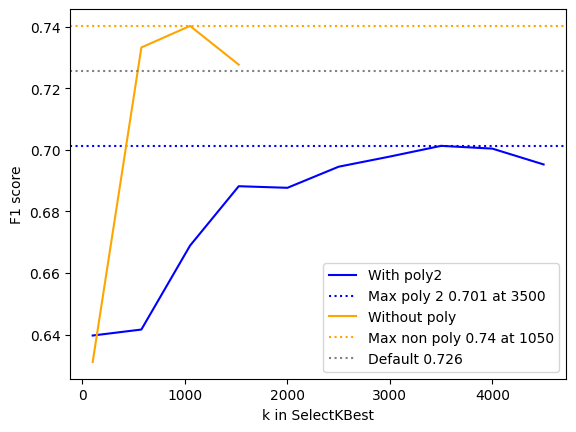

In [308]:
plot_k_range_results(k_range_results_rc)

In [366]:
%%time
svd_range_results_rc = svd_n_range_scores(complete_pipeline, 
                                          np.linspace(100, 1000, 10, dtype=int),
                                          no_poly_k=1050,
                                          poly_2_k=3500,
                                          defaults={
                                              'url_cleaner': [None],
                                              'vectorizer__text_c_vect__stop_words': [stopwords_english],
                                              'classifier': [model_rc]
                                          })

Pure Text {'poly2_k_best': ['passthrough']}
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
No Poly, Best 1050 {'poly2_k_best__poly2': ['passthrough'], 'poly2_k_best__k_best__k': [1050]}
CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.29 µs
Poly 2, Best 3500 {'poly2_k_best__k_best__k': [3500]}
CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.29 µs
CPU times: user 23min 12s, sys: 13min 11s, total: 36min 24s
Wall time: 15min 15s


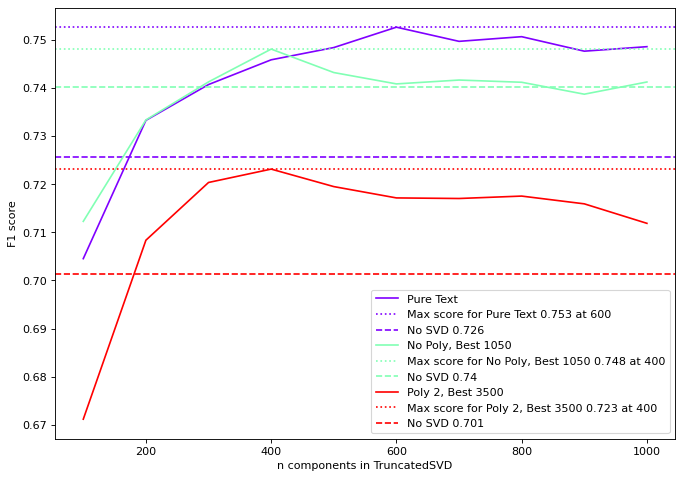

In [397]:
plot_svd__range_results(svd_range_results_rc)

In [309]:
%%time
k_range_results_lr = k_range_scores(complete_pipeline, 
                                    np.concatenate((np.linspace(100, 2000, 5, dtype=int), np.linspace(2500, 4500, 5, dtype=int))),
                                       default_params={
                                           'url_cleaner': [None],
                                           'svd': [None],
                                           'classifier': [model_lr]
                                       })

CPU times: user 12min 8s, sys: 18.5 s, total: 12min 26s
Wall time: 12min 1s


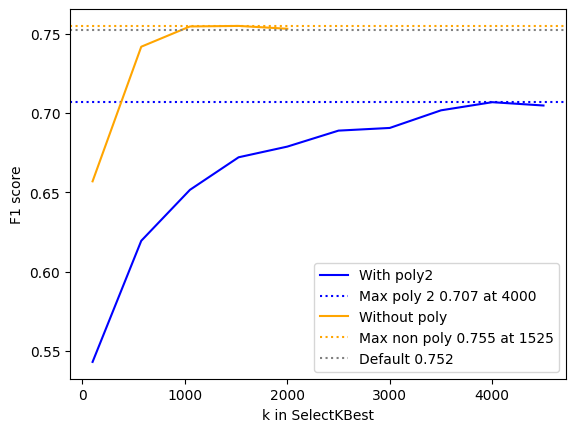

In [310]:
plot_k_range_results(k_range_results_lr)

In [367]:
%%time
svd_range_results_lr = svd_n_range_scores(complete_pipeline, 
                                          np.linspace(100, 1000, 10, dtype=int),
                                          no_poly_k=1525,
                                          poly_2_k=4000,
                                          defaults={
                                              'url_cleaner': [None],
                                              'classifier': [model_lr]
                                          })

Pure Text {'poly2_k_best': ['passthrough']}
CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.58 µs
No Poly, Best 1525 {'poly2_k_best__poly2': ['passthrough'], 'poly2_k_best__k_best__k': [1525]}
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Poly 2, Best 4000 {'poly2_k_best__k_best__k': [4000]}
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs
CPU times: user 25min 34s, sys: 12min 31s, total: 38min 6s
Wall time: 17min 54s


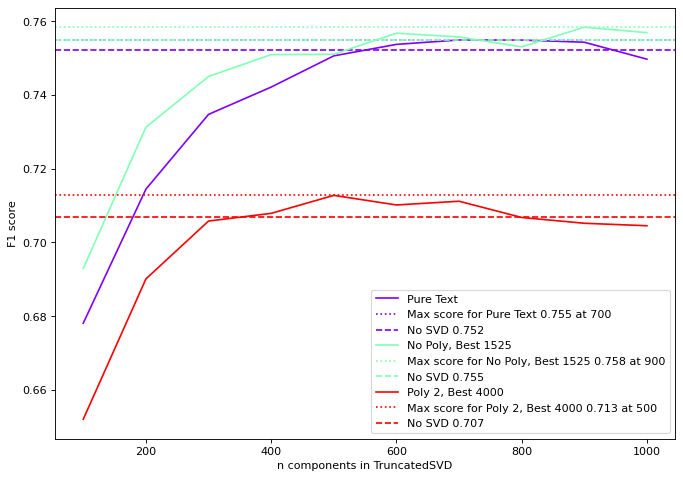

In [398]:
plot_svd__range_results(svd_range_results_lr)

In [260]:
%%time
k_range_results_tree = k_range_scores(complete_pipeline, 
                                     np.concatenate((np.linspace(200, 800, 4, dtype=int), (np.linspace(1000, 6000, 4, dtype=int)))),
                                       default_params={
                                           'url_cleaner': [None],
                                           'vectorizer': [text_vectorizer_transformer],
                                           'vectorizer__text_c_vect__preprocessor': [stem_preprocessor],
                                           'vectorizer__text_c_vect__stop_words': [stopwords_english],
                                           'svd': [None],
                                           'classifier': [model_tree]
                                       })


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokeni

CPU times: user 7min 4s, sys: 15.8 s, total: 7min 20s
Wall time: 7min


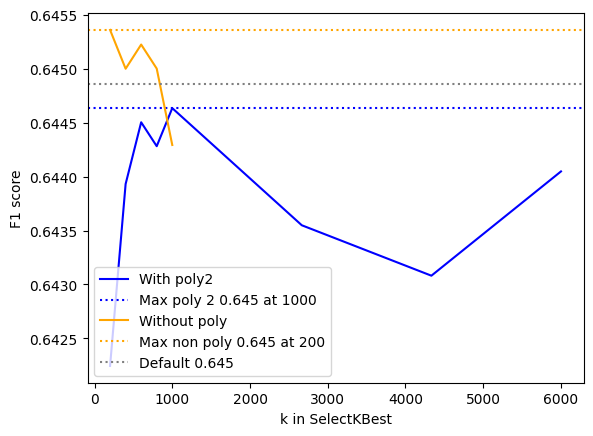

In [311]:
plot_k_range_results(k_range_results_tree)

In [368]:
%%time
svd_range_results_tree = svd_n_range_scores(complete_pipeline, 
                                          np.linspace(100, 1000, 10, dtype=int),
                                          no_poly_k=200,
                                          poly_2_k=1000,
                                          defaults={
                                           'url_cleaner': [None],
                                           'vectorizer': [text_vectorizer_transformer],
                                           'vectorizer__text_c_vect__preprocessor': [stem_preprocessor],
                                           'vectorizer__text_c_vect__stop_words': [stopwords_english],
                                           'classifier': [model_tree]
                                          })

Pure Text {'poly2_k_best': ['passthrough']}
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.34 µs


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokeni

No Poly, Best 200 {'poly2_k_best__poly2': ['passthrough'], 'poly2_k_best__k_best__k': [200]}
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.81 µs


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokeni

Poly 2, Best 1000 {'poly2_k_best__k_best__k': [1000]}
CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.81 µs


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokeni

CPU times: user 16min 11s, sys: 5min 34s, total: 21min 45s
Wall time: 12min 19s


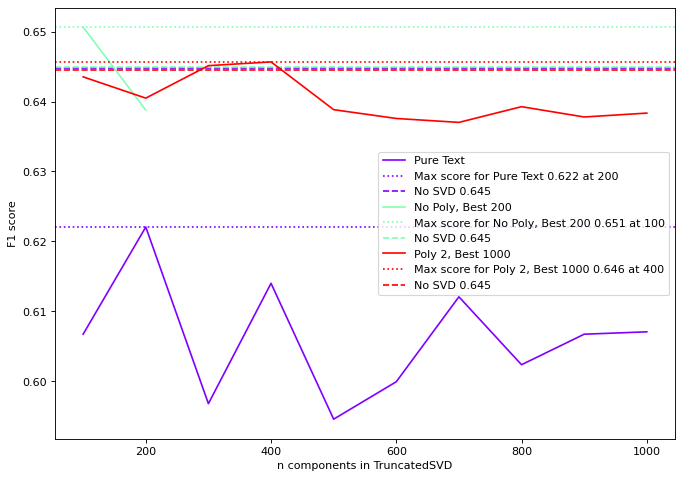

In [399]:
plot_svd__range_results(svd_range_results_tree)

In [259]:
%%time
k_range_results_forest = k_range_scores(complete_pipeline, 
                                     np.concatenate((np.linspace(200, 800, 4, dtype=int), (np.linspace(1000, 6000, 4, dtype=int)))),
                                       default_params={
                                           'url_cleaner': [None],
                                           'vectorizer': [text_vectorizer_transformer],
                                           'vectorizer__text_c_vect__preprocessor': [stem_preprocessor],
                                           'svd': [None],
                                           'classifier': [model_forest]
                                       })

CPU times: user 7min 48s, sys: 16 s, total: 8min 4s
Wall time: 7min 43s


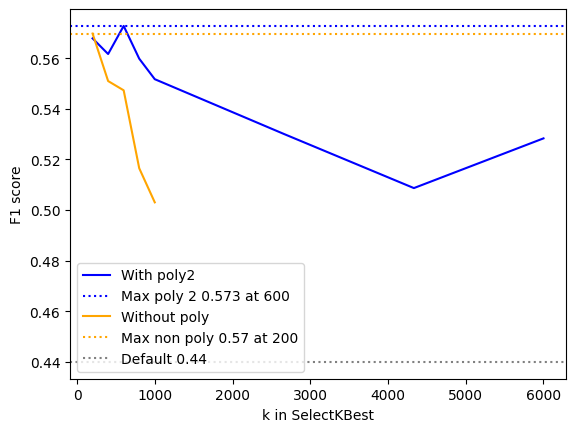

In [312]:
plot_k_range_results(k_range_results_forest)

In [369]:
%%time
svd_range_results_forest = svd_n_range_scores(complete_pipeline, 
                                          np.linspace(100, 1000, 10, dtype=int),
                                          no_poly_k=200,
                                          poly_2_k=600,
                                          defaults={
                                           'url_cleaner': [None],
                                           'vectorizer': [text_vectorizer_transformer],
                                           'vectorizer__text_c_vect__preprocessor': [stem_preprocessor],
                                           'classifier': [model_forest]
                                          })

Pure Text {'poly2_k_best': ['passthrough']}
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokeni

No Poly, Best 200 {'poly2_k_best__poly2': ['passthrough'], 'poly2_k_best__k_best__k': [200]}
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.58 µs


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokeni

Poly 2, Best 600 {'poly2_k_best__k_best__k': [600]}
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokeni

CPU times: user 15min 36s, sys: 4min 55s, total: 20min 31s
Wall time: 12min 36s


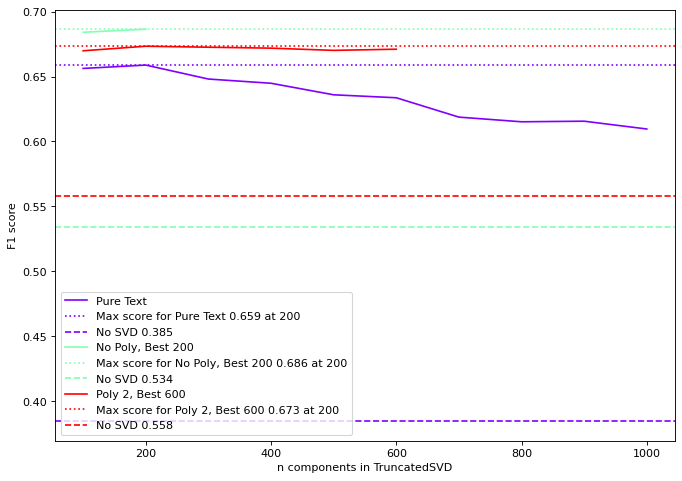

In [400]:
plot_svd__range_results(svd_range_results_forest)

In [261]:
%%time
k_range_results_xgb = k_range_scores(complete_pipeline, 
                                     np.concatenate((np.linspace(200, 800, 4, dtype=int), (np.linspace(1000, 6000, 4, dtype=int)))),
                                       default_params={
                                           'url_cleaner': [None],
                                           'vectorizer': [text_hashtags_vectorizer_transformer],
                                           'vectorizer__text_c_vect__preprocessor': [stem_preprocessor],
                                           'vectorizer__text_c_vect__stop_words': [stopwords_english],
                                           'svd': [None],
                                           'classifier': [model_xgb]
                                       })

/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokeni

CPU times: user 7min 55s, sys: 15.3 s, total: 8min 10s
Wall time: 7min 25s


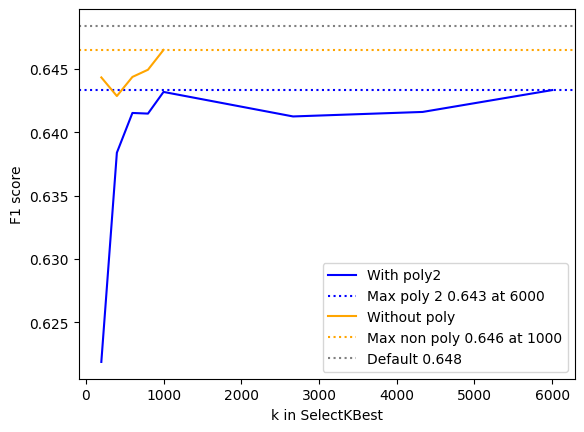

In [313]:
plot_k_range_results(k_range_results_xgb)

In [370]:
%%time
svd_range_results_xgb = svd_n_range_scores(complete_pipeline, 
                                          np.linspace(100, 1000, 10, dtype=int),
                                          no_poly_k=1000,
                                          poly_2_k=6000,
                                          defaults={
                                           'url_cleaner': [None],
                                           'vectorizer': [text_hashtags_vectorizer_transformer],
                                           'vectorizer__text_c_vect__preprocessor': [stem_preprocessor],
                                           'vectorizer__text_c_vect__stop_words': [stopwords_english],
                                           'classifier': [model_xgb]
                                          })

Pure Text {'poly2_k_best': ['passthrough']}
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokeni

No Poly, Best 1000 {'poly2_k_best__poly2': ['passthrough'], 'poly2_k_best__k_best__k': [1000]}
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokeni

Poly 2, Best 6000 {'poly2_k_best__k_best__k': [6000]}
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokeni

CPU times: user 36min 55s, sys: 11min 11s, total: 48min 7s
Wall time: 15min 25s


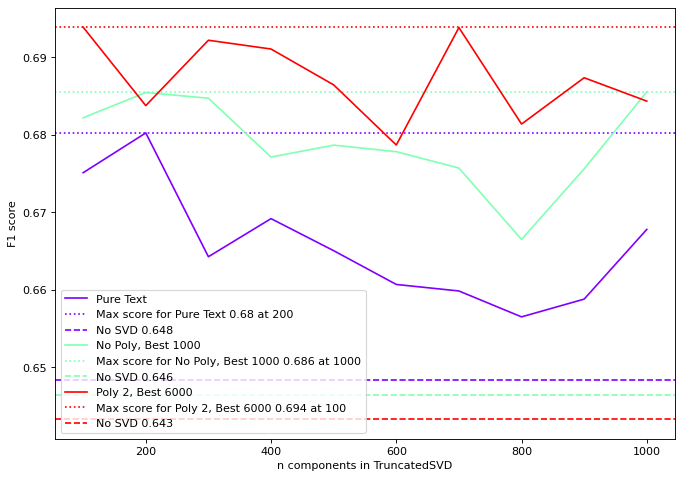

In [401]:
plot_svd__range_results(svd_range_results_xgb)

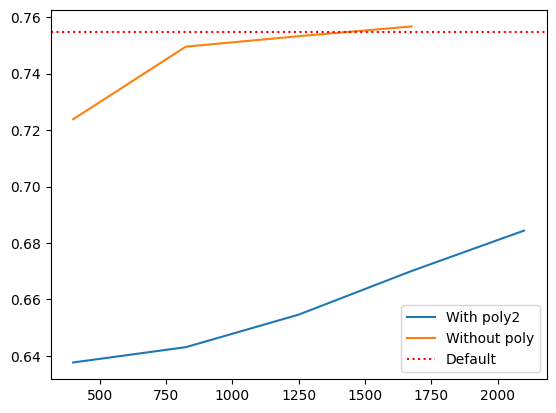

In [243]:
plot_k_range_results(k_range_results_nb)

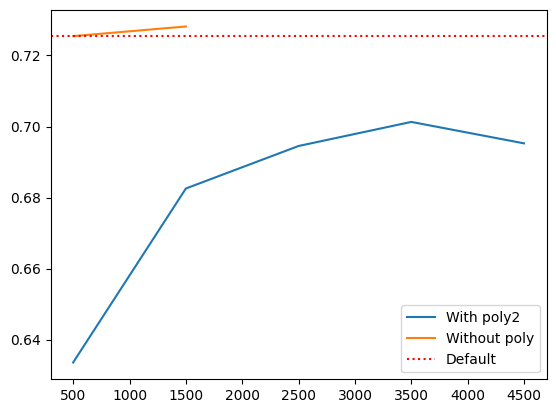

In [245]:
plot_k_range_results(k_range_results_rc)

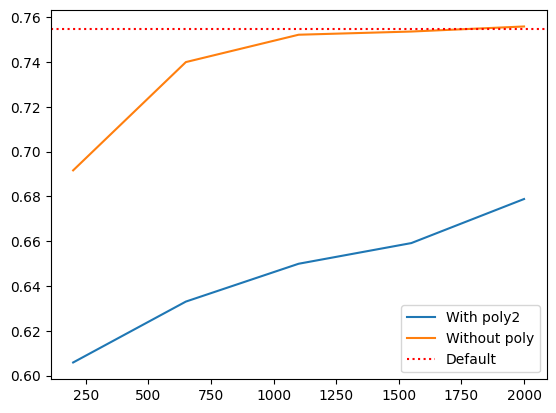

In [224]:
plt.plot(k_range.data, poly2_scores, label='With poly2')
plt.plot(k_range.data, non_poly_scores, label='Without poly')
plt.axhline(y = default_score, color = 'r', linestyle = ':', label='Default')
plt.legend()

In [200]:
default_nb_grid_result.cv_results_

{'mean_fit_time': array([0.06367815]),
 'std_fit_time': array([0.0010121]),
 'mean_score_time': array([0.02005959]),
 'std_score_time': array([0.00137987]),
 'param_poly2_k_best': masked_array(data=[None],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'poly2_k_best': None}],
 'split0_test_score': array([0.78056426]),
 'split1_test_score': array([0.758405]),
 'split2_test_score': array([0.75197472]),
 'split3_test_score': array([0.7281399]),
 'mean_test_score': array([0.75477097]),
 'std_test_score': array([0.01867842]),
 'rank_test_score': array([1], dtype=int32)}

In [182]:
nb_grid_result.best_params_

{'k_best': 'passthrough', 'poly2': PolynomialFeatures(degree=1)}

In [178]:
def grid_search(pipe, param_grid, X, y):
    grid_search = GridSearchCV(pipe, 
                               param_grid = param_grid,
                               scoring='f1',
                               cv=model_selection.StratifiedKFold(4, shuffle=True, random_state=42)) 
    grid_search.fit(X, y)
    print("Tuned Hyperparameters :", grid_search.best_params_)
    print(f"F1 score : {grid_search.best_score_}")
    print("________________________")
    return grid_search

In [147]:
X_grid = df_full_train[['text', 'keyword']]
y_grid = y_full_train

In [203]:
X_sandbox = X_grid.copy()
dict_sandbox = X_grid[['keyword']].to_dict(orient='records')
d_s = dict_sandbox.copy()
d_s[0] = {'keyword': 'hui'}
series_sandbox = pd.Series(dict_sandbox)
X_sandbox.keyword = series_sandbox
DictVectorizer().fit_transform(d_s) == DictVectorizer().fit_transform(series_sandbox)

/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3378: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


False

In [274]:
initial_columns = ['text', 'keyword', 'hashtags', 'location']
initial_columns = ['text', 'hashtags']

def columns_prepare(df):
    return df[initial_columns]


def sparse_to_df(sm):
    return pd.DataFrame.sparse.from_spmatrix(sm)

text_v_transformer = ('vect', ColumnTransformer([('c_vect', CountVectorizer(min_df=5), 'text')], remainder='passthrough'))
ht_v_transformer = ColumnTransformer([('c_vect', CountVectorizer(min_df=5), 'hashtags')], remainder='passthrough')
columns_prepare_transformer = FunctionTransformer(columns_prepare)
columns_cleanup_transformer = FunctionTransformer(columns_cleanup)

vectorizer_transformer = ColumnTransformer([('c_vect', CountVectorizer(min_df=5), 'text'),
                                           ('ht_c_vect', CountVectorizer(min_df=5, analyzer=lambda x: []
                                                                        ),
                                            'hashtags')])

In [275]:
df_full_train.hashtags

4996      [hiroshima70]
3263     [boycottbears]
4907                 []
2855                 []
4716    [pantherattack]
             ...       
5226                 []
5390                 []
860                  []
7603                 []
7270                 []
Name: hashtags, Length: 6090, dtype: object

In [216]:
%%time

nb_pipe = Pipeline(steps=[('columns_prepare', columns_prepare_transformer),
                            ('url_cleaner', url_cleaner),
                            ('text_vectorizer', text_v_transformer),
                            # ('hashtags_vectorizer', ht_v_transformer),
                            ('columns_cleanup', columns_cleanup_transformer),
                            ('classifier', model_nb)])

param_grid_nb = {
    # 'hashtags_vectorizer__c_vect__min_df': range(1, 10),
    # 'hashtags_vectorizer': ['passthrough', ht_v_transformer]
    # 'classifier__learning_rate': [0.02, 0.1, 0.2, 0.3, 1],
    # 'classifier__n_estimators': [10, 20, 50, 100, 200]
}

nb_result = grid_search(nb_pipe, param_grid_nb, df_full_train, y_grid)


ValueError: 
All the 4 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py", line 212, in transform
    return self._transform(X, func=self.func, kw_args=self.kw_args)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py", line 292, in _transform
    return func(X, **(kw_args if kw_args else {}))
  File "/tmp/ipykernel_355/1538304574.py", line 8, in columns_cleanup
    return df.drop(initial_columns, axis=1)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/scipy/sparse/_base.py", line 771, in __getattr__
    raise AttributeError(attr + " not found")
AttributeError: drop not found


In [184]:
nb_result.score(df_test[['text', 'keyword']], df_test['target'])

0.7312161115414408

In [57]:
def benchmark_steps(models={}, base_settings={}, variable_key=None, variable_list=[], benchmark_settings=default_preprocess_settings):
    vectors_dict = {}
    for value in variable_list:
        settings = base_settings.copy()
        settings.update({variable_key: value})
        vectors_dict[value] = prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv, settings=settings)

    benchmark_vectors_dict = {
        'benchmark': prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv, settings=benchmark_settings)
    }
    
    comparison = compare_models(models, vectors_dict)
    benchmark = compare_models(models, benchmark_vectors_dict)
    diff = comparison - benchmark.loc['benchmark']
    return diff

In [83]:
best_k_models = simple_models.copy()
best_k_models.update({'XGB Boost': model_xgb})

In [84]:
%%time
best_ks_default = np.linspace(200, 2400, 12, dtype=int)
best_k_diffs_default = benchmark_steps(models=best_k_models, 
                base_settings=default_preprocess_settings, 
                variable_key='best_k', 
                variable_list=best_ks_default)

CPU times: user 22.1 s, sys: 31.3 ms, total: 22.1 s
Wall time: 11 s


Text(0.5, 1.0, 'Pure text plus variable Best K. F1 Difference with Pure Text')

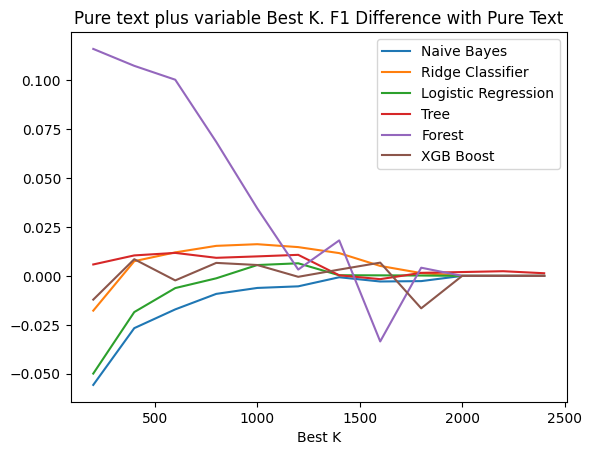

In [85]:
for col in best_k_diffs_default.columns:
    plt.plot(best_ks_default, best_k_diffs_default[col], label=col)
    plt.legend()
plt.xlabel('Best K')
plt.title('Pure text plus variable Best K. F1 Difference with Pure Text')    

In [86]:
%%time
best_ks_p2 = np.concatenate((np.linspace(200, 800, 7, dtype=int), (np.linspace(1000, 10000, 10, dtype=int))))
best_k_diffs_p2 = benchmark_steps(models=best_k_models, 
                base_settings=dict(default_preprocess_settings, max_poly=2), 
                variable_key='best_k', 
                variable_list=best_ks_p2)

CPU times: user 17min 18s, sys: 36 s, total: 17min 54s
Wall time: 16min 33s


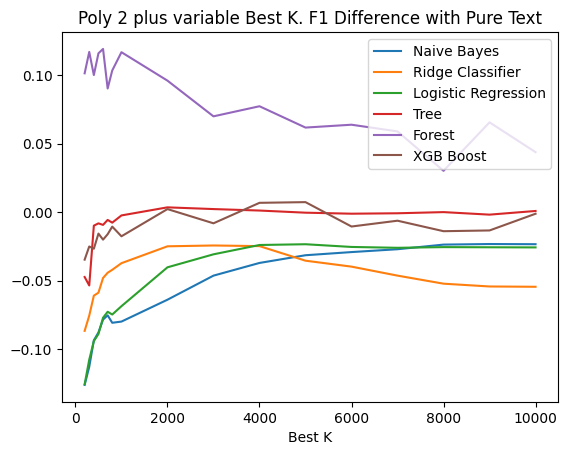

In [87]:
for col in best_k_diffs_p2.columns:
    plt.plot(best_ks_p2, best_k_diffs_p2[col], label=col)
    plt.legend()
    plt.xlabel('Best K')
    plt.title('Poly 2 plus variable Best K. F1 Difference with Pure Text')

In [70]:
svd_models = {
        'Ridge Classifier': model_rc,
        'Logistic Regression': model_lr,
        'Tree': model_tree,
        'Forest': model_forest,
        'XGB Boost': model_xgb
    }

In [77]:
%%time
svd_ns_default = np.linspace(100, 1100, 11, dtype=int)
svd_n_diffs_default = benchmark_steps(models=svd_models, 
                base_settings=default_preprocess_settings, 
                variable_key='svd_n_comp', 
                variable_list=svd_ns_default)

CPU times: user 19min 50s, sys: 13min 11s, total: 33min 1s
Wall time: 6min 37s


Text(0.5, 1.0, 'Pure text plus truncated SVD with variable n components. F1 Difference with Pure Text')

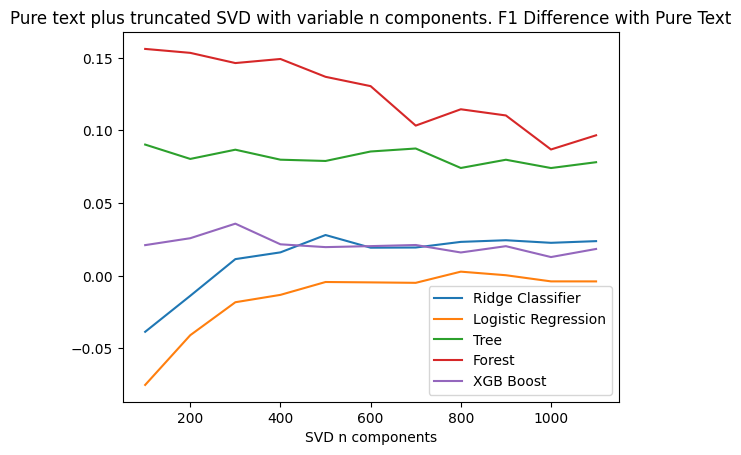

In [78]:
for col in svd_n_diffs_default.columns:
    plt.plot(svd_ns_default, svd_n_diffs_default[col], label=col)
    plt.legend()
plt.xlabel('SVD n components')
plt.title('Pure text plus truncated SVD with variable n components. F1 Difference with Pure Text')

In [74]:
%%time
svd_ns_p2_k1000 = np.linspace(100, 900, 9, dtype=int)
svd_n_diff_p2_k1000 = benchmark_steps(models=svd_models, 
                base_settings=dict(default_preprocess_settings, max_poly=2, best_k=1000),
                variable_key='svd_n_comp', 
                variable_list=svd_ns_p2_k1000)

CPU times: user 14min 47s, sys: 6min 6s, total: 20min 53s
Wall time: 9min 30s


Text(0.5, 1.0, 'Poly 2 and Best 1000 plus truncated SVD with variable n components. F1 Difference with Pure Text')

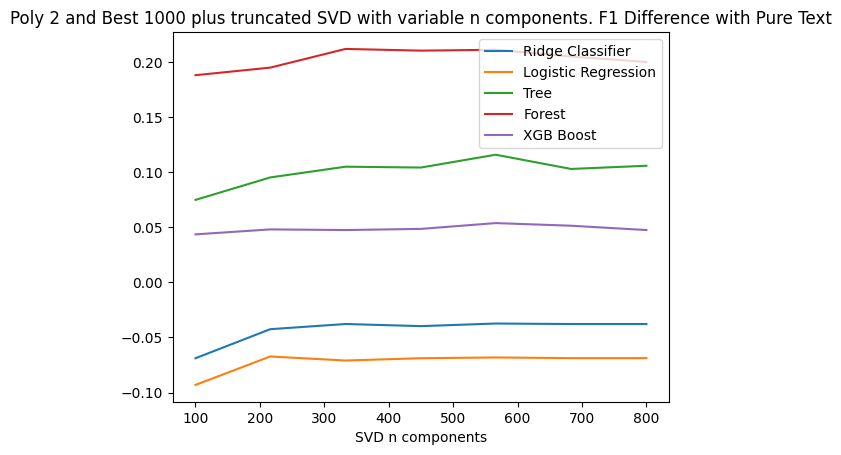

In [75]:
for col in svd_n_diff_p2_k1000.columns:
    plt.plot(svd_ns_p2_k1000, svd_n_diff_p2_k1000[col], label=col)
    plt.legend()
plt.xlabel('SVD n components')
plt.title('Poly 2 and Best 1000 plus truncated SVD with variable n components. F1 Difference with Pure Text')

In [80]:
%%time
svd_ns_p2_k4000 = np.linspace(100, 1000, 10, dtype=int)
svd_n_diff_p2_k4000 = benchmark_steps(models=svd_models, 
                base_settings=dict(default_preprocess_settings, max_poly=2, best_k=4000) ,
                variable_key='svd_n_comp', 
                variable_list=svd_ns_p2_k4000)

CPU times: user 29min 57s, sys: 15min, total: 44min 58s
Wall time: 16min 39s


Text(0.5, 1.0, 'Poly 2 and Best 4000 plus truncated SVD with variable n components. F1 Difference with Pure Text')

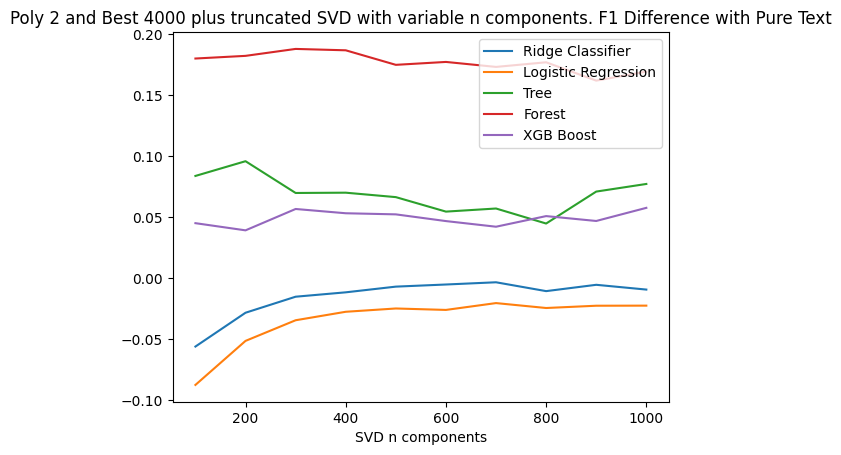

In [81]:
for col in svd_n_diff_p2_k4000.columns:
    plt.plot(svd_ns_p2_k4000, svd_n_diff_p2_k4000[col], label=col)
    plt.legend()
plt.xlabel('SVD n components')
plt.title('Poly 2 and Best 4000 plus truncated SVD with variable n components. F1 Difference with Pure Text')

#### Several conclusions
For different models here are the data preparation steps that bring positive differences in F1 score:
1. Naive Bayes:
URL Cleaner, Keyword vectorization
2. Ridge Classifier:
URL Cleaner, Keyword vectorization, BestK(k = 4000-6000), SVD Truncated (n_components ~500)
3. Logistic Regression
URL Cleaner*, Keyword vectorization, BestK(1000-1200), SVD Truncated* (n_components ~800)
4. Decision Tree Classifier
URL Cleaner, Keyword vectorization, BestK(k = 4000-6000), SVD Truncated (n_components ~500)
5. Random Forest Classifier
URL Cleaner, Poly 2 + BestK (k ~1000) + SVD Truncated (n_components ~300-400)
*effect is neutral, but we'll keep it to play with different model settings during the Grid Search

### Dimensionality reduction

Let's see which preprocessing steps are adding more to the score comparing it to the pure `text` case

In [58]:
nb_vectors = prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
                                      settings=dict(default_settings, kw=True, url_cleaner=url_cleaner))
rc_vectors = prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
                                      settings=dict(default_settings, kw=True, url_cleaner=url_cleaner))
lr_vectors =  prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
                                      settings=dict(default_settings, kw=True, url_cleaner=url_cleaner))
tree_vectors =  prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
                                      settings=dict(default_settings, kw=True, url_cleaner=url_cleaner, preprocessor=lemma_preprocessor_full,
                                                   stopwords=stopwords_english))
# forest_vectors =  prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
#                                       settings=default_settings)

In [59]:
simple_combined_vectors = {
    'Naive Bayes': nb_vectors,
    'Ridge Classifier': rc_vectors,
    'Logistic Regression': lr_vectors,
    'Tree': tree_vectors,
}

record_dict = {
        'Features': 'Best combo'
    }


for key, data in simple_combined_vectors.items():
    model = simple_models[key]
    record_dict[key] = round(my_cross_val_score(model, data['splits']).mean(), 3)
        
record_df = pd.DataFrame([record_dict]).set_index('Features')
simple_df_combi = pd.concat([simple_comparison_df, record_df])
simple_df_combi

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest
Features,,,,,
text,0.746,0.723,0.747,0.490,0.447
url_clean,0.750,0.723,0.747,0.497,0.329
stem,0.743,0.723,0.741,0.509,0.467
lemma_full,0.735,0.713,0.729,0.579,0.410
lemma_adj,0.731,0.709,0.730,0.574,0.373
lemma_adverb,0.732,0.708,0.731,0.575,0.364
lemma_verb,0.729,0.715,0.732,0.579,0.376
lemma_noun,0.732,0.708,0.731,0.574,0.364
stopwords,0.743,0.720,0.738,0.633,0.370


We see improvements comparing to all "atomic" steps everywhere except for the Tree model. The best result it shows with only stopwords applied. Let's replace the data for the Tree model:

### Adding SVD

In [60]:
%%time
svd_vectors_combinations = {
}

def add_svd_combi(key, combi):
    print(f'adding {key}')
    svd_vectors_combinations[key] = combi

add_svd_combi('url_clean_kw_text', prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
              settings=dict(default_settings, kw=True, url_cleaner=url_cleaner)))

add_svd_combi('url_clean_kw_text_svd_200', prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
              settings=dict(default_settings, svd_n_comp=200, kw=True, url_cleaner=url_cleaner)))
add_svd_combi('url_clean_kw_text_svd_400', prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
              settings=dict(default_settings, svd_n_comp=400, kw=True, url_cleaner=url_cleaner)))
add_svd_combi('url_clean_kw_text_svd_700', prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
              settings=dict(default_settings, svd_n_comp=700, kw=True, url_cleaner=url_cleaner)))
add_svd_combi('url_clean_kw_text_svd_1000', prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
              settings=dict(default_settings, svd_n_comp=1000, kw=True, url_cleaner=url_cleaner)))

add_svd_combi('ht_url_clean_kw_text_svd_700', prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
              settings=dict(default_settings, svd_n_comp=700, kw=True, url_cleaner=url_cleaner, hashtags=True)))
add_svd_combi('stem_url_clean_kw_text_svd_700', prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
              settings=dict(default_settings, svd_n_comp=700, kw=True, url_cleaner=url_cleaner, preprocessor=stem_preprocessor)))
add_svd_combi('stopwords_url_clean_kw_text_svd_700', prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
              settings=dict(default_settings, svd_n_comp=700, kw=True, url_cleaner=url_cleaner, stopwords=stopwords_english)))
add_svd_combi('stopwords_stem_url_clean_kw_text_svd_700', prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
              settings=dict(default_settings, svd_n_comp=700, kw=True, url_cleaner=url_cleaner, preprocessor=stem_preprocessor, stopwords=stopwords_english)))
add_svd_combi('lemma_url_clean_kw_text_svd_700', prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
              settings=dict(default_settings, svd_n_comp=700, kw=True, url_cleaner=url_cleaner, preprocessor=lemma_preprocessor_full)))

add_svd_combi('2ng_url_clean_kw_text_svd_700', prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
              settings=dict(default_settings, svd_n_comp=700, kw=True, url_cleaner=url_cleaner, ngram_range=(1,2))))
add_svd_combi('3ng_url_clean_kw_text_svd_700', prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
              settings=dict(default_settings, svd_n_comp=700, kw=True, url_cleaner=url_cleaner, ngram_range=(1,3))))

add_svd_combi('poly_2_best_10000_url_clean_kw_svd_700', prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv, 
                                      settings=dict(default_settings, max_poly=2, best_k=10000, svd_n_comp=700, kw=True, url_cleaner=url_cleaner)))

add_svd_combi('stem_url_clean_kw_text_svd_700', prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
              settings=dict(default_settings, svd_n_comp=700, kw=True, url_cleaner=url_cleaner, preprocessor=stem_preprocessor)))

adding url_clean_kw_text
adding url_clean_kw_text_svd_200
adding url_clean_kw_text_svd_400
adding url_clean_kw_text_svd_700
adding url_clean_kw_text_svd_1000
adding ht_url_clean_kw_text_svd_700
adding stem_url_clean_kw_text_svd_700
adding stopwords_url_clean_kw_text_svd_700
adding stopwords_stem_url_clean_kw_text_svd_700
adding lemma_url_clean_kw_text_svd_700
adding 2ng_url_clean_kw_text_svd_700
adding 3ng_url_clean_kw_text_svd_700
adding poly_2_best_10000_url_clean_kw_svd_700
adding stem_url_clean_kw_text_svd_700
CPU times: user 16min 13s, sys: 18min 44s, total: 34min 57s
Wall time: 6min 18s


In [61]:
add_svd_combi('url_clean_kw_text', prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
              settings=dict(default_settings, kw=True, url_cleaner=url_cleaner)))

adding url_clean_kw_text


In [62]:
%%time
svd_models = {
        'Ridge Classifier': model_rc,
        'Logistic Regression': model_lr,
        'Tree': model_tree,
        'xgb': model_xgb
    }

svd_comparison_df = compare_models(svd_models, svd_vectors_combinations)
svd_diffs = svd_comparison_df - svd_comparison_df.loc['url_clean_kw_text']

CPU times: user 10min 2s, sys: 50.9 s, total: 10min 53s
Wall time: 2min 50s


In [63]:
svd_comparison_df

,Ridge Classifier,Logistic Regression,Tree,xgb
Features,,,,
url_clean_kw_text,0.724,0.750,0.496,0.590
url_clean_kw_text_svd_200,0.721,0.711,0.575,0.649
url_clean_kw_text_svd_400,0.750,0.745,0.563,0.644
url_clean_kw_text_svd_700,0.752,0.753,0.574,0.632
url_clean_kw_text_svd_1000,0.749,0.749,0.552,0.633
ht_url_clean_kw_text_svd_700,0.750,0.756,0.543,0.630
stem_url_clean_kw_text_svd_700,0.752,0.753,0.566,0.640
stopwords_url_clean_kw_text_svd_700,0.745,0.751,0.623,0.678
stopwords_stem_url_clean_kw_text_svd_700,0.747,0.745,0.598,0.675


In [64]:
svd_diffs

,Ridge Classifier,Logistic Regression,Tree,xgb
Features,,,,
url_clean_kw_text,0.000,0.000,0.000,0.000
url_clean_kw_text_svd_200,-0.003,-0.039,0.079,0.059
url_clean_kw_text_svd_400,0.026,-0.005,0.067,0.054
url_clean_kw_text_svd_700,0.028,0.003,0.078,0.042
url_clean_kw_text_svd_1000,0.025,-0.001,0.056,0.043
ht_url_clean_kw_text_svd_700,0.026,0.006,0.047,0.040
stem_url_clean_kw_text_svd_700,0.028,0.003,0.070,0.050
stopwords_url_clean_kw_text_svd_700,0.021,0.001,0.127,0.088
stopwords_stem_url_clean_kw_text_svd_700,0.023,-0.005,0.102,0.085


In [308]:
svd_diffs[model_key].min()

0.0

<BarContainer object of 13 artists>

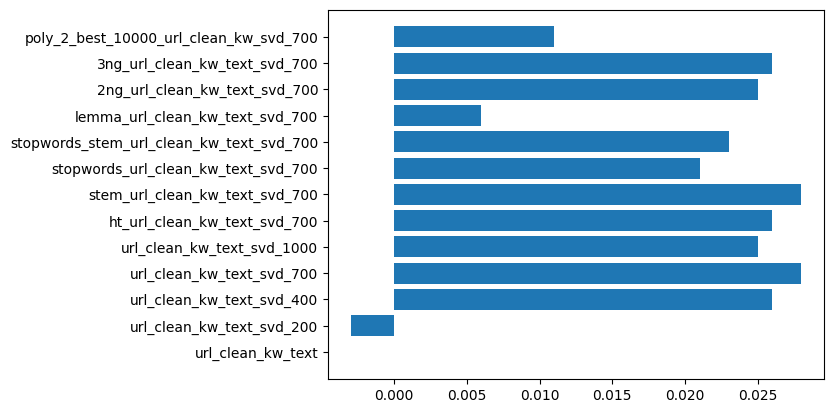

In [310]:
# for model_key in svd_models:
model_key='Ridge Classifier'
plt.barh(svd_diffs.index, width=(svd_diffs[model_key]).to_list())

### Finding best number of SVD components per model

In [65]:
%%time
svd_sets = {}
svd_n_range = range(50, 951, 100)
for n in svd_n_range:
    svd_sets[n] = prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv,
              settings=dict(default_settings, kw=True, url_cleaner=url_cleaner, svd_n_comp=n))

CPU times: user 7min 57s, sys: 10min 10s, total: 18min 8s
Wall time: 2min 33s


In [66]:
%%time
svd_model_scores = {}
for key, model in svd_models.items():
    scores = []
    for n, data in svd_sets.items():
        scores.append(my_cross_val_score(model, data['splits']).mean())
    svd_model_scores[key] = scores


CPU times: user 6min 22s, sys: 37.8 s, total: 6min 59s
Wall time: 1min 48s


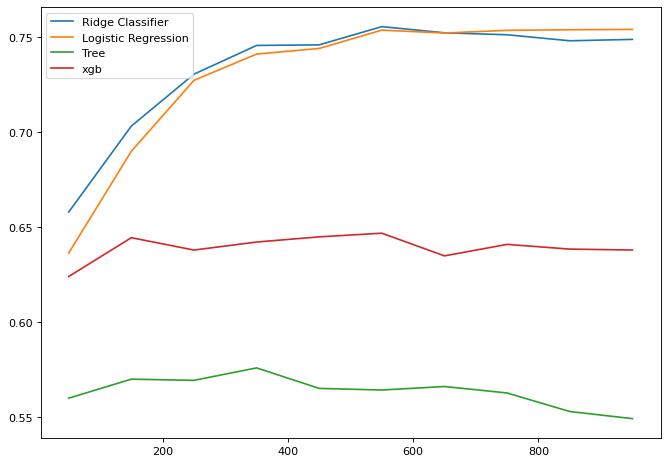

In [67]:


figure(figsize=(10, 7), dpi=80)

for key, scores in svd_model_scores.items():
    plt.plot(svd_n_range, scores, label=key)
    plt.legend()

## Hyperparameter optimization with Pipeline and Grid Search

In [158]:
%%time

rc_pipe = Pipeline(steps=[('url_cleaner', url_cleaner),
                          ('vectorizer', vectorizer_transformer),
                          ('svd', TruncatedSVD(n_components=550)),
                          ('classifier', RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced"))])
param_grid_rc = {
    'classifier__alpha': np.logspace(-3,2,6),
    'classifier__solver': ['lsqr', 'saga', 'sag'],
}

rc_result = grid_search(rc_pipe, param_grid_rc, X_grid, y_grid)
rc_result

Tuned Hyperparameters : {'classifier__alpha': 1.0, 'classifier__solver': 'saga'}
F1 score : 0.7565697371181807
________________________
CPU times: user 6min 21s, sys: 7min 2s, total: 13min 23s
Wall time: 2min 17s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=55, shuffle=True),
             estimator=Pipeline(steps=[('url_cleaner',
                                        FunctionTransformer(func=<function url_clean at 0x7f8d38c05090>)),
                                       ('vectorizer',
                                        ColumnTransformer(transformers=[('c_vect',
                                                                         CountVectorizer(min_df=5),
                                                                         'text'),
                                                                        ('kw_dict_vect',
                                                                         Pipeline(steps=[('kw_to_dict',
                                                                                          FunctionTransformer(func=<function kw_to_dict at 0x7f8d2525caf0>)),
                                                                                         ('d_vect',
                                                                                          DictVectorizer())]),
                                                                         'keyword')])),
                                       ('svd', TruncatedSVD(n_components=550)),
                                       ('classifier',
                                        RidgeClassifier(class_weight='balanced',
                                                        max_iter=500,
                                                        random_state=42))]),
             param_grid={'classifier__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'classifier__solver': ['lsqr', 'saga', 'sag']},
             scoring='f1')

In [161]:
%%time

lr_pipe = Pipeline(steps=[('url_cleaner', url_cleaner),
                          ('vectorizer', vectorizer_transformer),
                          ('svd', TruncatedSVD(n_components=550)),
                          ('classifier', model_lr)])
param_grid_lr = {
    'classifier__C': np.logspace(-3,2,6),
    'classifier__solver': ['lbfgs', 'liblinear', 'sag', 'saga']
}

lr_result = grid_search(lr_pipe, param_grid_lr, X_grid, y_grid)
lr_result

/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model

Tuned Hyperparameters : {'classifier__C': 1.0, 'classifier__solver': 'sag'}
F1 score : 0.753169445923299
________________________
CPU times: user 11min 46s, sys: 11min 20s, total: 23min 6s
Wall time: 5min 30s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=55, shuffle=True),
             estimator=Pipeline(steps=[('url_cleaner',
                                        FunctionTransformer(func=<function url_clean at 0x7f8d38c05090>)),
                                       ('vectorizer',
                                        ColumnTransformer(transformers=[('c_vect',
                                                                         CountVectorizer(min_df=5),
                                                                         'text'),
                                                                        ('kw_dict_vect',
                                                                         Pipeline(steps=[('kw_to_dict',
                                                                                          FunctionTransformer(func=<function kw_to_dict at 0x7f8d2525caf0>)),
                                                                                         ('d_vect',
                                                                                          DictVectorizer())]),
                                                                         'keyword')])),
                                       ('svd', TruncatedSVD(n_components=550)),
                                       ('classifier',
                                        LogisticRegression(max_iter=500,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'classifier__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'classifier__solver': ['lbfgs', 'liblinear', 'sag',
                                                'saga']},
             scoring='f1')

In [162]:
%%time

xgb_pipe = Pipeline(steps=[('url_cleaner', url_cleaner),
                          ('vectorizer', vectorizer_transformer),
                          ('svd', TruncatedSVD(n_components=550)),
                          ('classifier', model_xgb)])

# (learning_rate=0.2,
#                           n_estimators=10, 
#                           max_depth=7, 
#                           min_child_weight=1, 
#                           objective="binary:logistic", 
#                           seed=42)

param_grid_xgb = {
    'classifier__learning_rate': [0.02, 0.1, 0.2, 0.3, 1],
    'classifier__n_estimators': [10, 20, 50, 100, 200]
}

xgb_result = grid_search(xgb_pipe, param_grid_xgb, X_grid, y_grid)

Tuned Hyperparameters : {'classifier__learning_rate': 0.3, 'classifier__n_estimators': 200}
F1 score : 0.6990668833332087
________________________
CPU times: user 1h 48min 58s, sys: 10min 48s, total: 1h 59min 46s
Wall time: 15min 13s


In [163]:
%%time

param_grid_xgb_weights = {
    'classifier__learning_rate': [0.2, 0.3, 0.4],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 7, 10, 15, 25]
}

xgb_result_weights = grid_search(xgb_pipe, param_grid_xgb_weights, X_grid, y_grid)

Tuned Hyperparameters : {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}
F1 score : 0.7051399536156417
________________________
CPU times: user 7h 33min 27s, sys: 15min 52s, total: 7h 49min 19s
Wall time: 59min 10s


In [165]:
%%time

param_grid_xgb_weights = {
    'classifier__learning_rate': [0.15, 0.2, 0.25],
    'classifier__n_estimators': [400, 500],
    'classifier__max_depth': [2, 3, 5]
}

xgb_result_weights = grid_search(xgb_pipe, param_grid_xgb_weights, X_grid, y_grid)

Tuned Hyperparameters : {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 400}
F1 score : 0.7129559918230834
________________________
CPU times: user 3h 32min 2s, sys: 7min 28s, total: 3h 39min 31s
Wall time: 27min 41s


In [332]:
%%time

param_grid_nb = {
    'alpha': np.logspace(-3,2,6)
}

param_grid_rc = {
    'alpha': np.logspace(-3,2,6),
    'solver': ['lsqr', 'saga', 'sag'],
}

param_grid_lr = {
    'C': np.logspace(-3,2,6),
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga']
}

param_grid_tree = {
    'criterion': ['gini', 'enthropy'],
    'max_depth': range(12, 19),
    'min_samples_split': range(1, 4),
    'min_samples_leaf': range(5, 10)
}

param_grid_forest = {
    'max_depth': [60, 80, 100, 120, 140],
    'max_features': [3, 4, 5, 6, 7],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [8, 10, 12, 14, 16],
    'n_estimators': [50, 70, 90, 110]
}

param_grids_dict = {
    'Naive Bayes': param_grid_nb,
    'Ridge Classifier': param_grid_rc,
    'Logistic Regression': param_grid_lr,
    'Tree': param_grid_tree,
    'Forest': param_grid_forest    
}
model_lr = LogisticRegression(max_iter=500, random_state=42)
grids_lr = {}

rRidgeClassifierd_dict = {
        'Features': 'Optimized'
    }

# grid_search('Naive Bayes', param_grid_nb)

# grid_search('Tree', param_grid_tree)

grid_search('Forest', param_grid_forest)

# for key, model in models.items():
    
#     grid_search = GridSearchCV(model,
#                        param_grid = param_grids_dict[key],
#                        scoring='f1',
#                        cv=cv) 
#     grid_search.fit(combined_vectors[key]['vectors'], df_full_train.target)
#     print(f"Optimization for {key}")
#     print("Tuned Hyperparameters :", grid_search.best_params_)
#     print(f"F1 score : {grid_search.best_score_}")
#     print("________________________")
#     record_dict[key] = round(grid_search.best_score_, 3)

# record_df = pd.DataFrame([record_dict]).set_index('Features')
# df2 = pd.concat([df1, record_df])
# df2

Optimization for Forest
Tuned Hyperparameters : {'max_depth': 140, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 50}
F1 score : 0.7018068327065458
________________________
CPU times: user 26min 33s, sys: 3.43 s, total: 26min 37s
Wall time: 26min 37s


0.7018068327065458

In [316]:
model_key = 'Ridge Classifier'
output_2342 = combined_vectors[model_key]
output_2342 = train_vectors_combinations['text']
test_data = prepare_test_vectors(output_2342)
model = models[model_key]
model.fit(output_2342['vectors'], df_full_train.target)
y_pred = model.predict(test_data)
# y_pred.shape
f1_score(df_test.target, y_pred)df_combi

0.7321565617805066

Some observations:
- adding the `keywords` feature slightly improves the score, while adding `location` feature tents to reduce it, which accords with our `mutual_info_score` findings.
- adding 2- and 3-ngrams reduces the score
- the best result is shown with combination of `text` and `keyword` features and Logistic Regression model

In [54]:
# (train_vectors_combinations['text_kw_loc'].shape[1], 
# train_vectors_combinations['text_2ng_kw_loc'].shape[1], 

The dimensionality is too high for more sophisticated methods. Also it can happen that our columns contain some words that actually reduce the score

TruncatedSVD is a way to reduce number of features in sparse matrices. It's a variation of PCA approach: reducing vector space dimensionality by finding more "informative" axes

### Helpers for multiple models training

In [56]:
from sklearn.decomposition import TruncatedSVD
from IPython.display import clear_output

def truncated_vectors(features, components_range, n_iter=20):
    n_work = sum([train_vectors_combinations[k].shape[1] for k in features])
    c_work = sum(coarse_components_range)    
    total_work = n_work*c_work
    done_work = 0
    
    result = {}
    for f in features:
        dict = {}
        for n in components_range:
            clear_output(wait=True)
            done_percentage = round(100*done_work/total_work)
            print(f"{done_percentage}% completed")
            iter_work = n*train_vectors_combinations[f].shape[1]
            iter_percentage = round(100*iter_work/total_work)
            print (f"Processing {n} components in {f} ({iter_percentage}%)")
            svd = TruncatedSVD(n_components=n, n_iter=20, random_state=42)
            vectors = svd.fit_transform(train_vectors_combinations[f])
            dict[n] = vectors
            done_work+=iter_work
        result[f] = dict
    return result

In [57]:
coarse_components_range = range(50, 1251, 300)
coarse_features = ['text', 
                   'text_kw',
                   'text_kw_loc', 
                   'text_2ng_kw_loc', 
                   'text_poly_kw_loc_best_1600', 
                   'text_poly_kw_loc_best_10000', 
                   'text_poly_kw_loc_best_20000', 
                   'text_poly_2ng_kw_loc_best_20000']
coarse_truncated_vectors = truncated_vectors(coarse_features, coarse_components_range)

88% completed
Processing 1250 components in text_poly_2ng_kw_loc_best_20000 (12%)


In [58]:
import time
from datetime import timedelta

In [59]:
def calculate_scores(truncated_vectors, models, random_state=42, additional_vectors=None):
    scores_dicts = []
    
    cv = model_selection.StratifiedKFold(4, shuffle=True, random_state=42)

    total_work = sum([len(dict) for dict in truncated_vectors.values()]) * len(models)
    done_work = 0
    start_time = time.time()
    
    for f, dict in truncated_vectors.items():
        for model_name, model in models.items():
            model_scores = []
            comp_range = dict.keys()
            for n in comp_range:
                clear_output(wait=True)
                done_ratio = done_work/total_work
                done_percentage = round(100*done_ratio)
                time_passed = time.time() - start_time
                time_left = "Unknown" if done_work==0 else timedelta(seconds=round((1-done_ratio)*time_passed/done_ratio))
                print(f"{done_percentage}% completed. Time passed: {round(time_passed)}. Time left: {time_left}")
                vectors = dict[n]
                if additional_vectors is not None:
                    vectors = sp.hstack((vectors, additional_vectors))                
                print(f"{f} {model_name} {n} components")
                model_scores.append(model_selection.cross_val_score(model, vectors, df_full_train["target"], cv=cv, scoring="f1").mean())    
                done_work += 1
            scores_dicts.append({
                'feature': f,
                'model': model_name,
                'comp_range': comp_range,
                'scores': model_scores
            })
    print ("Done")
    return scores_dicts

### Multiple models

In [58]:
tree_model = DecisionTreeClassifier(max_depth=7)
forest_model = RandomForestClassifier(n_estimators=50,
                            max_depth=7,
                            min_samples_leaf=2,
                            random_state=42)
xgb_model = XGBClassifier(learning_rate=0.2,
                          n_estimators=50, 
                          max_depth=7, 
                          min_child_weight=1, 
                          objective="binary:logistic", 
                          seed=42)

models = {
    'Naive Bayes': nb_model,
    'Ridge Classifier': model_rc,
    'Logistic Regression': model_lr,
    'Tree': tree_model,
    'Random Forest': forest_model,
    'XGBoost': xgb_model
}

NameError: name 'model_rc' is not defined

In [61]:
%%time
scores_dicts = calculate_scores(coarse_truncated_vectors, models)

100% completed. Time passed: 1514. Time left: 0:00:08
text_poly_2ng_kw_loc_best_20000 XGBoost 1250 components
Done
CPU times: user 2h 6min 41s, sys: 2min 59s, total: 2h 9min 40s
Wall time: 25min 55s


In [62]:
def plot_scores(scores, canvas=plt):
    for dict in scores:
        canvas.plot(dict['comp_range'], dict['scores'], label=f"{dict['model']} {dict['feature']}")
        canvas.ylabel("f1 score")
        canvas.xlabel("n_components")
    canvas.legend()

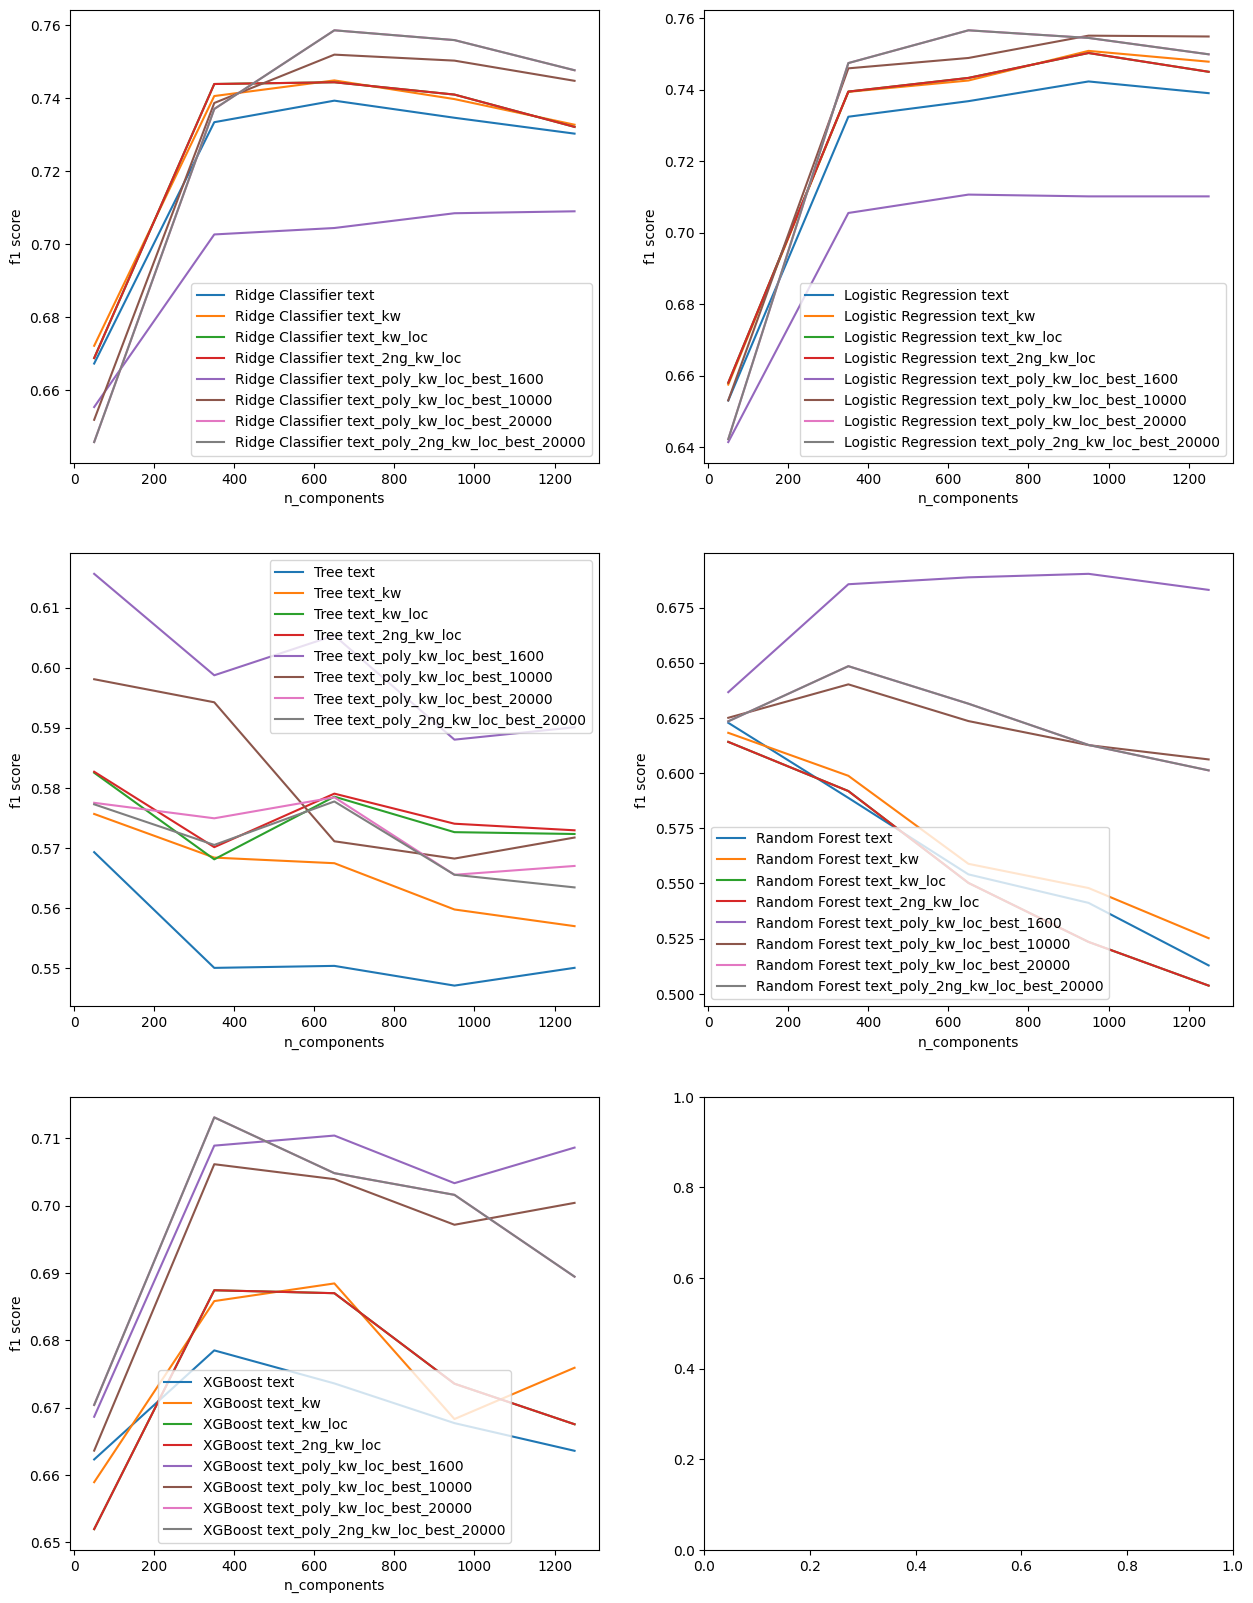

In [63]:
fig, ax = plt.subplots(3, 2, figsize=(15,20))
i = 1
for model_name in models:
    plt.subplot(3, 2, i) 
    plot_scores([d for d in scores_dicts if d['model'] == model_name])
    i+=1

The most interesting results are shown by Ridge Classifier and Logistic Regression on range 400-800 on the set text_poly_kw_loc_best_10000. Let's zoom in

In [64]:
fine_components_range = range(400, 801, 50)
fine_features = ['text_poly_kw_loc_best_20000']
fine_truncated_vectors = truncated_vectors(fine_features, fine_components_range)

142% completed
Processing 800 components in text_poly_kw_loc_best_20000 (25%)


In [65]:
%%time
fine_models = {    
    'Ridge Classifier': model_rc,
    'Logistic Regression': model_lr
}

fine_scores_dicts = calculate_scores(fine_truncated_vectors, fine_models)

94% completed. Time passed: 40. Time left: 0:00:02
text_poly_kw_loc_best_20000 Logistic Regression 800 components
Done
CPU times: user 56.8 s, sys: 39.1 s, total: 1min 35s
Wall time: 46.7 s


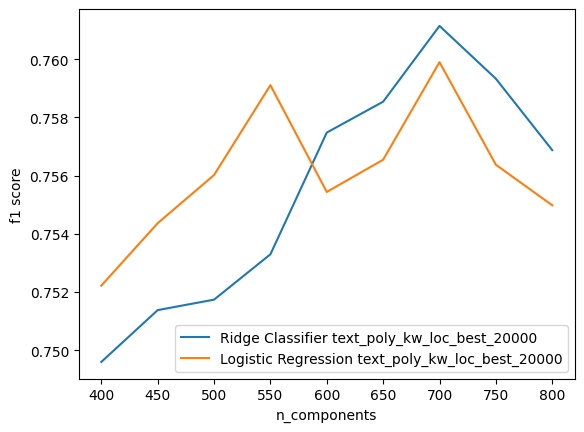

In [66]:
# fig, ax = plt.subplots(3, 2, figsize=(15,20))
# i = 1
for model_name in fine_models:
    # plt.subplot(3, 2, i) 
    plot_scores([d for d in fine_scores_dicts if d['model'] == model_name])
    # i+=1

In [67]:
hashtag_pattern = r'(?u)#\w+\b'

df_additional = pd.DataFrame()
df_additional['text_len'] = df_full_train.text.str.len()
df_additional['keyword_in_text'] = df_full_train.apply(lambda x: x.keyword.lower() in x.text.lower(), axis=1).astype(int)
df_additional['location_in_text'] = df_full_train.apply(lambda x: x.location.lower() in x.text.lower(), axis=1).astype(int)
df_additional['url_count'] = df_full_train.text.str.count(url_pattern)
df_additional['hashtag_count'] = df_full_train.text.str.count(hashtag_pattern)
df_additional['target'] = df_full_train['target']

df_additional.corr()

,text_len,keyword_in_text,location_in_text,url_count,hashtag_count,target
text_len,1.000000,-0.038747,-0.048554,0.300063,0.211123,0.179213
keyword_in_text,-0.038747,1.000000,0.025828,-0.055649,0.015896,-0.077753
location_in_text,-0.048554,0.025828,1.000000,0.008580,0.007032,0.006323
url_count,0.300063,-0.055649,0.008580,1.000000,0.189393,0.199078
hashtag_count,0.211123,0.015896,0.007032,0.189393,1.000000,0.061895
target,0.179213,-0.077753,0.006323,0.199078,0.061895,1.000000


<AxesSubplot: >

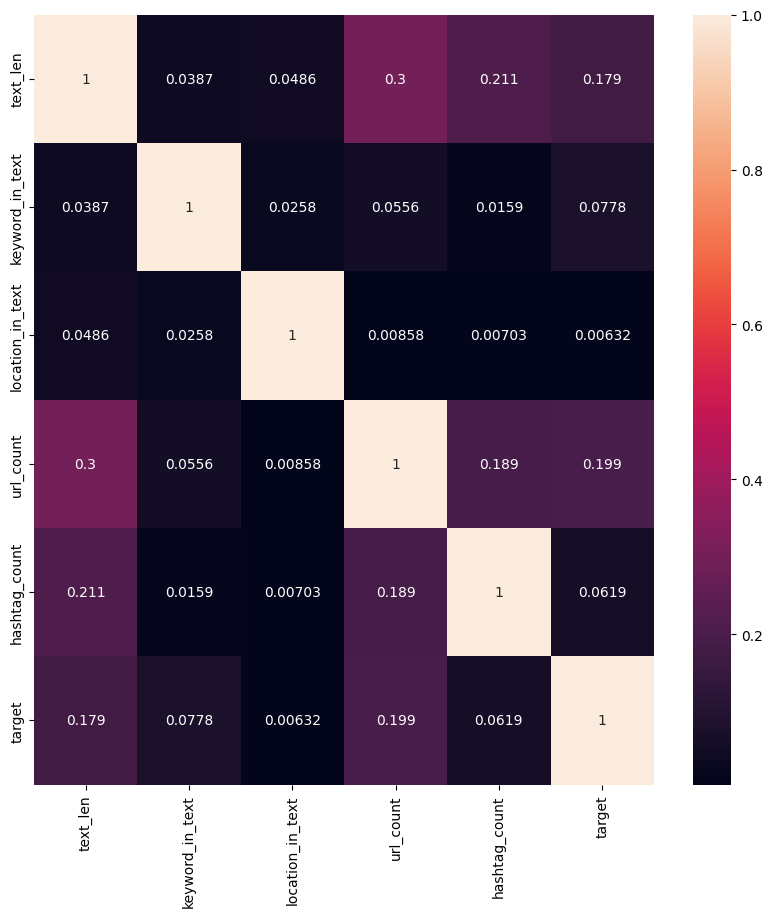

In [68]:
fig, ax = plt.subplots(figsize=(10,10)) 
cor_dfP = np.abs(df_additional.corr())
sns.heatmap(cor_dfP, annot=True, ax=ax, fmt='.3g')

In [69]:
additional = sp.csr_matrix(df_additional[['text_len', 'url_count']].values)
fine_with_additional_scores = calculate_scores(fine_truncated_vectors, fine_models, additional_vectors=additional)

94% completed. Time passed: 43. Time left: 0:00:03
text_poly_kw_loc_best_20000 Logistic Regression 800 components
Done


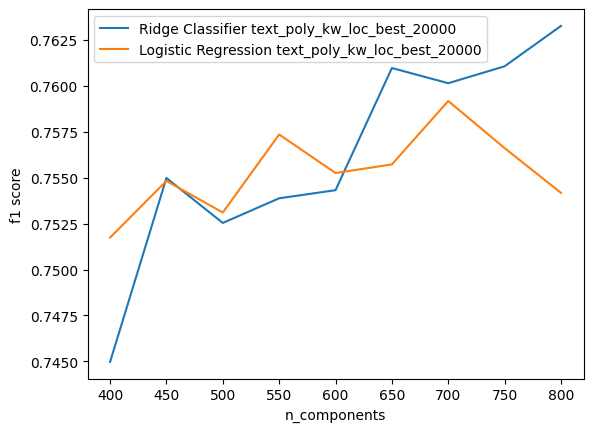

In [70]:
for model_name in fine_models:
    plot_scores([d for d in fine_with_additional_scores if d['model'] == model_name])

Additional columns do not add any value

## Fine tuning Logistic Regression

In [71]:
# model_rc = RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced")

lr_models = {}
max_iter_range = range(10, 50, 10)
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
for s in solvers:
    lr_models[s] = LogisticRegression(solver=s, C=1.0, max_iter=50, random_state=42)

lr_scores = calculate_scores(fine_truncated_vectors, lr_models)

98% completed. Time passed: 130. Time left: 0:00:03
text_poly_kw_loc_best_20000 saga 800 components


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


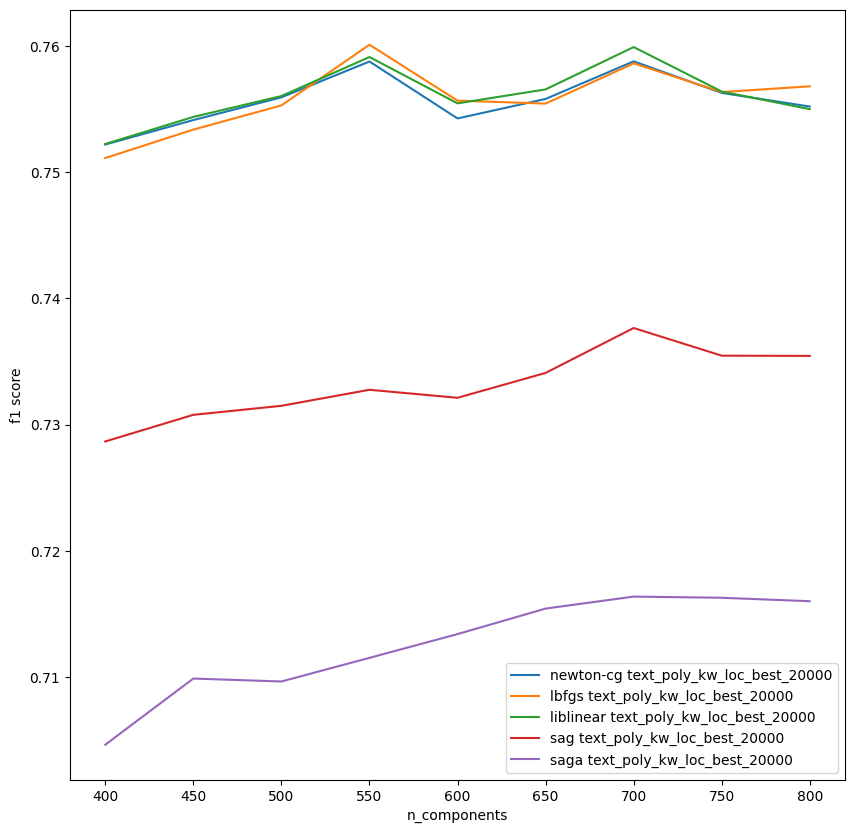

In [72]:
plt.subplots(figsize=(10,10)) 
for model_name in lr_models:
    if model_name != "Logistic Regression with 950 max iterations":
        plot_scores([d for d in lr_scores if d['model'] == model_name])

In [73]:
lr_models = {}
saga_components_range = range(700, 1001, 50)
saga_truncated_vectors = truncated_vectors(['text_poly_kw_loc_best_20000'], saga_components_range)

solvers = ['sag', 'saga']
for s in solvers:
    lr_models[s] = LogisticRegression(solver=s, C=1.0, max_iter=1000, random_state=42)

lr_scores = calculate_scores(saga_truncated_vectors, lr_models)

93% completed. Time passed: 2889. Time left: 0:03:42
text_poly_kw_loc_best_20000 saga 1000 components


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


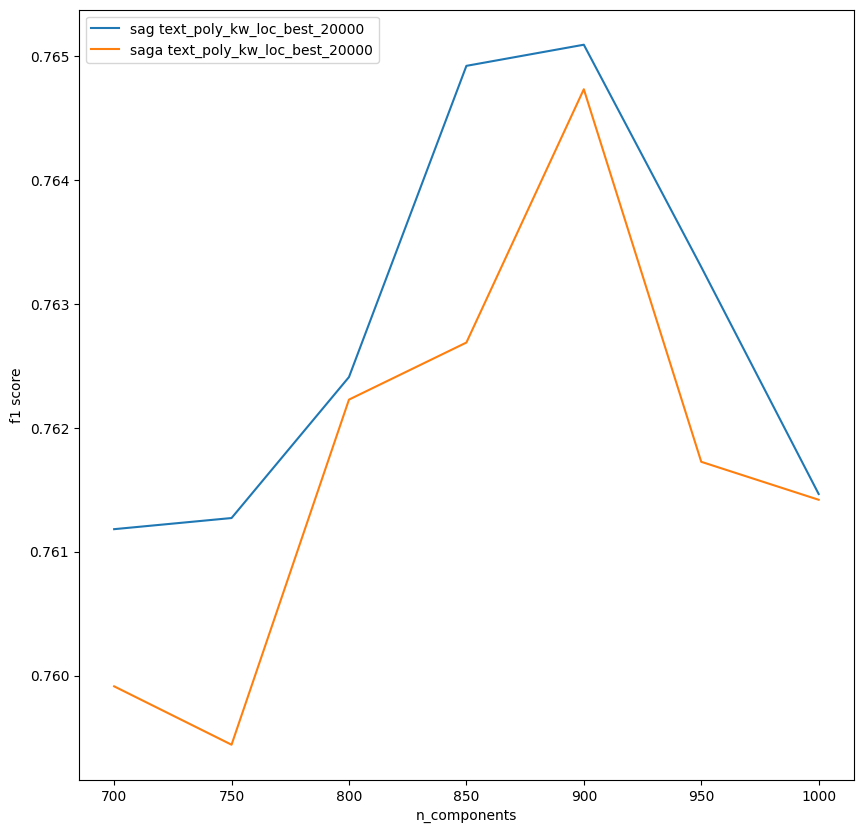

In [74]:
plt.subplots(figsize=(10,10)) 
for model_name in lr_models:
    if model_name != "Logistic Regression with 950 max iterations":
        plot_scores([d for d in lr_scores if d['model'] == model_name])

In [75]:
lr_models = {}
saga_components_range = range(1000, 1151, 50)
saga_truncated_vectors = truncated_vectors(['text_poly_kw_loc_best_20000'], saga_components_range)

solvers = ['sag']
for s in solvers:
    lr_models[s] = LogisticRegression(solver=s, C=1.0, max_iter=1000, random_state=42)

lr_scores = calculate_scores(saga_truncated_vectors, lr_models)

75% completed. Time passed: 350. Time left: 0:01:57
text_poly_kw_loc_best_20000 sag 1150 components


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


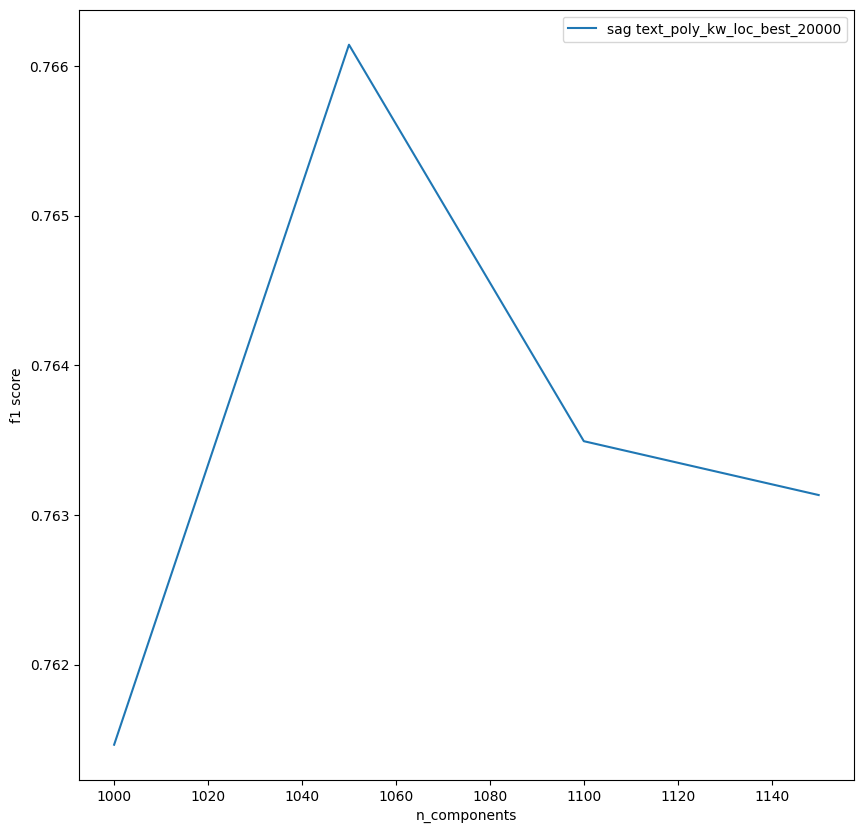

In [76]:
plt.subplots(figsize=(10,10)) 
for model_name in lr_models:
    if model_name != "Logistic Regression with 950 max iterations":
        plot_scores([d for d in lr_scores if d['model'] == model_name])

In [77]:
def prepare_data_tkl_poly(df, k_best=20000, svd_n_components=1000):
    min_df = 5
    c_vectorizer = CountVectorizer(min_df=min_df, analyzer=stemmer_analyzer)
    d_vectorizer = DictVectorizer()

    kw_loc_dict = df[['keyword', 'location']].to_dict(orient='records')

    kw_loc_vectors = d_vectorizer.fit_transform(kw_loc_dict)
    text_vectors = c_vectorizer.fit_transform(df.text)

    text_kw_loc_vectors = sp.hstack((text_vectors, kw_loc_vectors))
    p_features = PolynomialFeatures(2)
    text_kw_loc_poly_vectors = p_features.fit_transform(text_kw_loc_vectors)
    s_k_best = SelectKBest(chi2, k=k_best)
    best_vectors = s_k_best.fit_transform(text_kw_loc_poly_vectors, df.target)
    
    svd = TruncatedSVD(n_components=svd_n_components, n_iter=20, random_state=42)
    vectors = svd.fit_transform(best_vectors)
    
    return {
        'c_vect': c_vectorizer,
        'd_vect': d_vectorizer,
        'p_feat': p_features,
        's_k_best': s_k_best,
        'svd': svd,
        'vectors': vectors
    }

In [78]:
def prepare_test_data_tkl_poly(df, train_data):
    c_vectorizer = train_data['c_vect']
    d_vectorizer = train_data['d_vect']
    p_features = train_data['p_feat']
    s_k_best = train_data['s_k_best']
    svd = train_data['svd']
    
    kw_loc_dict = df[['keyword', 'location']].to_dict(orient='records')

    kw_loc_vectors = d_vectorizer.transform(kw_loc_dict)
    text_vectors = c_vectorizer.transform(df.text)

    text_kw_loc_vectors = sp.hstack((text_vectors, kw_loc_vectors))
   
    text_kw_loc_poly_vectors = p_features.transform(text_kw_loc_vectors)
    best_vectors = s_k_best.transform(text_kw_loc_poly_vectors)
    
    vectors = svd.transform(best_vectors)
    
    return vectors

## Train and test winner models

In [79]:
%%time
train_data_sag = prepare_data_tkl_poly(df_full_train, svd_n_components=1000)
test_data_sag = prepare_test_data_tkl_poly(df_test, train_data_sag)

CPU times: user 1h 23min 39s, sys: 16min 1s, total: 1h 39min 40s
Wall time: 1h 38min 10s


In [80]:
stemmer.stem('blown')

'blown'

In [81]:
%%time
model_lr_sag = LogisticRegression(solver="sag", C=1.0, max_iter=1000, random_state=42)
model_lr_sag.fit(train_data_sag['vectors'], df_full_train.target)
f1_score(df_test.target, model_lr_sag.predict(test_data_sag))

CPU times: user 37.4 s, sys: 0 ns, total: 37.4 s
Wall time: 37.4 s


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7613542526837325

In [82]:
%%time
train_data_rc = prepare_data_tkl_poly(df_full_train, svd_n_components=700)
test_data_rc = prepare_test_data_tkl_poly(df_test, train_data_rc)

CPU times: user 2min 44s, sys: 29.8 s, total: 3min 14s
Wall time: 2min 10s


In [83]:
%%time
model_rc = RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced")
model_rc.fit(train_data_rc['vectors'], df_full_train.target)
f1_score(df_test.target, model_rc.predict(test_data_rc))

CPU times: user 58.9 ms, sys: 235 ms, total: 294 ms
Wall time: 77.1 ms


0.7491909385113268

Stemmer + stopwords: 0.76, 0.75

Stemmer: 0.76, 0.75

Stopwords: 0.75, 0.74

Plain: 0.74, 0.75

Lemma: 0.75, 0.74

In [85]:
%%time
scorings_list = ['accuracy', 'f1', 'roc_auc']

parameters = {
    'penalty': ['l1', 'l2'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

model_lr = LogisticRegression(max_iter=500, random_state=42)
grids_lr = {}
for scoring in scorings_list:
    clf = GridSearchCV(model_lr,
                       param_grid = parameters,
                       scoring=scoring,
                       cv=cv) 
    clf.fit(train_data_rc['vectors'], df_full_train.target)
    print("Tuned Hyperparameters :", clf.best_params_)
    print(f"{scoring} :",clf.best_score_)
    print("________________________")
    grids_lr[scoring] = clf

Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.8213453718411428
________________________
Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l2', 'solver': 'sag'}
f1 : 0.7749059682772194
________________________
Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
roc_auc : 0.880072438164868
________________________
CPU times: user 44min 28s, sys: 6min 32s, total: 51min 1s
Wall time: 38min 41s


In [86]:
%%time
scorings_list = ['accuracy', 'f1', 'roc_auc']
parameters = {
    'alpha': [0.1, 0.5, 1, 2, 3, 4],
    'solver': ['lsqr', 'saga', 'sag'],
}

model_rc = RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced")
grids_rc = {}
for scoring in scorings_list:
    clf = GridSearchCV(model_rc,
                       param_grid = parameters,
                       scoring=scoring,
                       cv=cv) 
    clf.fit(train_data_rc['vectors'], df_full_train.target)
    print("Tuned Hyperparameters :", clf.best_params_)
    print(f"{scoring} :",clf.best_score_)
    print("________________________")
    grids_rc[scoring] = clf

Tuned Hyperparameters : {'alpha': 0.5, 'solver': 'saga'}
accuracy : 0.8164196943407395
________________________
Tuned Hyperparameters : {'alpha': 2, 'solver': 'sag'}
f1 : 0.7745214652653776
________________________
Tuned Hyperparameters : {'alpha': 4, 'solver': 'saga'}
roc_auc : 0.8777037458819706
________________________
CPU times: user 21min 22s, sys: 1min 20s, total: 22min 43s
Wall time: 20min 5s


In [92]:
pd.DataFrame(grids_rc['accuracy'].cv_results_)[['param_alpha', 'param_solver', 'mean_test_score', 'std_test_score']]

,param_alpha,param_solver,mean_test_score,std_test_score
0,0.1,lsqr,0.805582,0.009981
1,0.1,saga,0.816255,0.008197
2,0.1,sag,0.814121,0.008179
3,0.5,lsqr,0.805582,0.009981
4,0.5,saga,0.816420,0.008249
5,0.5,sag,0.814121,0.008179
6,1,lsqr,0.806074,0.009921
7,1,saga,0.816255,0.008197
8,1,sag,0.814121,0.008179
9,2,lsqr,0.806731,0.008809


In [93]:
pd.DataFrame(grids_rc['f1'].cv_results_)[['param_alpha', 'param_solver', 'mean_test_score', 'std_test_score']]

,param_alpha,param_solver,mean_test_score,std_test_score
0,0.1,lsqr,0.764547,0.015062
1,0.1,saga,0.773567,0.012115
2,0.1,sag,0.772884,0.012035
3,0.5,lsqr,0.764547,0.015062
4,0.5,saga,0.773725,0.012135
5,0.5,sag,0.772884,0.012035
6,1,lsqr,0.764989,0.015170
7,1,saga,0.773475,0.012106
8,1,sag,0.772794,0.012061
9,2,lsqr,0.765753,0.014674


In [94]:
pd.DataFrame(grids_rc['roc_auc'].cv_results_)[['param_alpha', 'param_solver', 'mean_test_score', 'std_test_score']]

,param_alpha,param_solver,mean_test_score,std_test_score
0,0.1,lsqr,0.867089,0.013634
1,0.1,saga,0.877488,0.011419
2,0.1,sag,0.875830,0.012074
3,0.5,lsqr,0.867272,0.013593
4,0.5,saga,0.877515,0.011381
5,0.5,sag,0.875883,0.012060
6,1,lsqr,0.867473,0.013526
7,1,saga,0.877542,0.011338
8,1,sag,0.875950,0.012024
9,2,lsqr,0.867985,0.013486


In [1]:
%%time
scorings_list = ['accuracy', 'f1', 'roc_auc']

parameters = {
    'penalty': ['l1', 'l2'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']
}

model_lr_big = LogisticRegression(max_iter=1000, random_state=42)
grids_lr_big = {}
for scoring in scorings_list:
    clf = GridSearchCV(model_lr,
                       param_grid = parameters,
                       scoring=scoring,
                       cv=cv) 
    clf.fit(train_data_sag['vectors'], df_full_train.target)
    print("Tuned Hyperparameters :", clf.best_params_)
    print(f"{scoring} :",clf.best_score_)
    print("________________________")
    grids_lr_big[scoring] = clf

NameError: name 'LogisticRegression' is not defined

In [96]:
current_time = datetime.now().strftime("%H:%M:%S")
print("Time finished =", current_time)

Time finished = 18:58:05
